<div style="border-radius: 15px; border: 2px solid #6A1B9A; padding: 20px; background: linear-gradient(135deg, #9C27B0, #4CAF50); text-align: center; box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.5);">
    <h1 style="color: #ffffff; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7); font-weight: bold; margin-bottom: 10px; font-size: 36px; font-family: 'Roboto', sans-serif;">
        🧠 SocialMind: Classifying Personality Traits
    </h1>
</div>

<!-- Include Google Fonts for a modern font -->
<link href="https://fonts.googleapis.com/css2?family=Roboto:wght@700&display=swap" rel="stylesheet">

This notebook aims to **classify individuals as Introverts or Extroverts** based on key **behavioral and psychological characteristics**. By leveraging social behavior indicators such as event participation, online activity, and emotional responses, we develop a predictive model to distinguish between personality types.

The data originates from the **Playground Series – Season 5, Episode 7** Kaggle challenge:
🎯 *“Predict the Introverts from the Extroverts”*.

### 📂 Dataset Overview

Three related datasets drive the analysis and modeling pipeline:

- **Original Dataset** (2,900 rows × 8 columns)  
  Contains foundational behavioral data with the `Personality` label. This balanced dataset reflects real-world distributions and serves as a benchmark for model evaluation.  

- **Train Dataset** (18,524 rows × 9 columns)  
  The primary labeled set for model training, including an `id`, behavioral features, and `Personality`. This dataset is larger and may contain synthetic or augmented samples.  

- **Test Dataset** (6,175 rows × 8 columns)  
  Unlabeled and structured identically to the train set (minus the target), intended for final model predictions.

### 🔎 Feature Summary

| **Feature**                 | **Type**                      | **Description**                               |
| --------------------------- | ----------------------------- | --------------------------------------------- |
| `Time_spent_Alone`          | Numerical (discrete)          | Hours spent alone daily *(0–11)*              |
| `Stage_fear`                | Categorical (nominal)         | Presence of stage fright *(Yes/No)*           |
| `Social_event_attendance`   | Numerical (discrete)          | Frequency of attending social events *(0–10)* |
| `Going_outside`             | Numerical (discrete)          | Frequency of going outside *(0–7)*            |
| `Drained_after_socializing` | Categorical (nominal)         | Feeling drained after socializing *(Yes/No)*  |
| `Friends_circle_size`       | Numerical (discrete)          | Number of close friends *(0–15)*              |
| `Post_frequency`            | Numerical (discrete)          | Social media post frequency *(0–10)*          |
| `Personality`               | Categorical (nominal, target) | Personality type: *Extrovert* or *Introvert*  |

> ℹ️ The features represent a combination of social interaction patterns, emotional tendencies, and lifestyle behaviors relevant to personality assessment.

### 🎯 Objectives

The core goal is to build a predictive model that accurately classifies an individual’s **Personality** as **Introvert** or **Extrovert**, using their social behaviors and psychological cues. This involves:

1. 🧹 **Data Exploration & Data Preparation**  
   - Analyze structure, missing values, and duplicates.  
   - Prepare data through imputation and encoding.
   - Handle missing values via **median imputation** for numerical features and **'missing' category** for categorical features.
   - Encode the target variable using **Label Encoding**.
   - Identify and flag **categorical features** explicitly for model handling.

2. 📊 **Exploratory Data Analysis (EDA)**  
   - Visualize feature distributions and correlations.  
   - Highlight differences between personality groups.

3. 🛠 **Modeling with CatBoostClassifier**
   - Utilize **CatBoost**, a powerful gradient boosting framework that handles categorical features natively and performs well with tabular data.
   - Set up **7-Fold Stratified Cross-Validation** to ensure model robustness and minimize bias from class distribution.
   - Evaluate using both **Accuracy** and **ROC AUC** to capture performance from both class-balance and probability-calibration perspectives.

4. 🧠 **Hyperparameter Optimization with Optuna**

   - Define a search space and use **Optuna** to automatically explore and find optimal hyperparameters that maximize validation **AUC**.
   - Integrate **early stopping** and **evaluation sets** during training to avoid overfitting.

5. 📈 **Performance Evaluation & Visualization**

   - Monitor **per-fold metrics** including Accuracy and AUC.
   - Plot **ROC Curves** for each fold.
   - Analyze **feature importance** from the final model.
   - Generate **classification report** and **confusion matrix** on out-of-fold predictions.

6. 📤 **Final Inference & Submission**

   - Use **majority voting** across ensemble predictions for test data.
   - Visualize distribution of predicted probabilities to inspect model calibration. 
   - Generate predictions on the test set in the required format.  

#### 💡 Why This Matters

This project demonstrates how **behavioral and psychological signals** such as time spent alone, social engagement, and emotional responses, can effectively inform **personality classification**. The contrast between the balanced **original dataset** and the skewed **competition data** highlights important issues of **data representation and model fairness**.

🔗 **References**  
- [Predict the Introverts from the Extroverts — Kaggle Playground Series S5E7](https://www.kaggle.com/competitions/playground-series-s5e7/data)  
- [Extrovert vs. Introvert Behavior Data — Kaggle Dataset](https://www.kaggle.com/datasets/rakeshkapilavai/extrovert-vs-introvert-behavior-data/data)

# <span style="color:transparent;">Import Libraries</span>

<div style="border-radius: 15px; border: 2px solid #6A1B9A; padding: 10px; background: linear-gradient(135deg, #9C27B0, #4CAF50); text-align: center; box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.5);">
    <h1 style="color: #ffffff; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7); font-weight: bold; margin-bottom: 5px; font-size: 28px; font-family: 'Roboto', sans-serif;">
        Import Libraries
    </h1>
</div>

<!-- Include Google Fonts for a modern font -->
<link href="https://fonts.googleapis.com/css2?family=Roboto:wght@700&display=swap" rel="stylesheet">


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from scipy.stats import skew
from IPython.display import display

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier, Pool
from IPython.display import display

import warnings
warnings.filterwarnings("ignore")

# <span style="color:transparent;">Load Data</span>

<div style="border-radius: 15px; border: 2px solid #6A1B9A; padding: 10px; background: linear-gradient(135deg, #9C27B0, #4CAF50); text-align: center; box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.5);">
    <h1 style="color: #ffffff; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7); font-weight: bold; margin-bottom: 5px; font-size: 28px; font-family: 'Roboto', sans-serif;">
        Load Data
    </h1>
</div>

<!-- Include Google Fonts for a modern font -->
<link href="https://fonts.googleapis.com/css2?family=Roboto:wght@700&display=swap" rel="stylesheet">


In [2]:
# Load the datasets
train_data = pd.read_csv('/kaggle/input/playground-series-s5e7/train.csv')
test_data = pd.read_csv('/kaggle/input/playground-series-s5e7/test.csv')
sample_data = pd.read_csv('/kaggle/input/playground-series-s5e7/sample_submission.csv')
original_data = pd.read_csv('/kaggle/input/extrovert-vs-introvert-behavior-data/personality_dataset.csv')

# Verify shapes
print("Original Data Shape:", original_data.shape)
print("\nTrain Data Shape:", train_data.shape)
print("\nTest Data Shape:", test_data.shape)


Original Data Shape: (2900, 8)

Train Data Shape: (18524, 9)

Test Data Shape: (6175, 8)


We are working with three main datasets:
- **Original Data:** 2,900 rows × 8 columns (from the original Extrovert vs. Introvert Behavior dataset)
- **Train Data:** 18,524 rows × 9 columns (includes an `id` column and the target `Personality`)
- **Test Data:** 6,175 rows × 8 columns (includes an `id` column, no target)

# <span style="color:transparent;">Data Preview and Initial Exploration</span>

<div style="border-radius: 15px; border: 2px solid #6A1B9A; padding: 10px; background: linear-gradient(135deg, #9C27B0, #4CAF50); text-align: center; box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.5);">
    <h1 style="color: #ffffff; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7); font-weight: bold; margin-bottom: 5px; font-size: 28px; font-family: 'Roboto', sans-serif;">
        Data Preview and Initial Exploration
    </h1>
</div>

<!-- Include Google Fonts for a modern font -->
<link href="https://fonts.googleapis.com/css2?family=Roboto:wght@700&display=swap" rel="stylesheet">


In [3]:
# Display few rows of each dataset
print("Original Data Preview:")
display(original_data.head())

print("\nTrain Data Preview:")
display(train_data.tail())

print("\nTest Data Preview:")
display(test_data.head())

Original Data Preview:


,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,4.0,No,4.0,6.0,No,13.0,5.0,Extrovert
1,9.0,Yes,0.0,0.0,Yes,0.0,3.0,Introvert
2,9.0,Yes,1.0,2.0,Yes,5.0,2.0,Introvert
3,0.0,No,6.0,7.0,No,14.0,8.0,Extrovert
4,3.0,No,9.0,4.0,No,8.0,5.0,Extrovert



Train Data Preview:


,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
18519,18519,3.0,No,7.0,3.0,No,9.0,7.0,Extrovert
18520,18520,1.0,NaN,6.0,7.0,No,6.0,5.0,Extrovert
18521,18521,7.0,Yes,1.0,1.0,Yes,1.0,NaN,Introvert
18522,18522,NaN,Yes,1.0,0.0,Yes,5.0,2.0,Introvert
18523,18523,1.0,No,8.0,6.0,No,4.0,7.0,Extrovert



Test Data Preview:


,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency
0,18524,3.0,No,7.0,4.0,No,6.0,NaN
1,18525,NaN,Yes,0.0,0.0,Yes,5.0,1.0
2,18526,3.0,No,5.0,6.0,No,15.0,9.0
3,18527,3.0,No,4.0,4.0,No,5.0,6.0
4,18528,9.0,Yes,1.0,2.0,Yes,1.0,1.0


A quick glance at the data reveals:

* Behavioral metrics are predominantly numeric.
* There are a few **categorical** features: `Stage_fear`, `Drained_after_socializing`, and `Personality` (target).
* The test dataset lacks the `Personality` column, as expected.

In [4]:
# Display information about the DataFrames
print("Original Data Info:")
original_data.info()

print("\nTrain Data Info:")
train_data.info()

print("\nTest Data Info:")
test_data.info()

Original Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2900 entries, 0 to 2899
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           2837 non-null   float64
 1   Stage_fear                 2827 non-null   object 
 2   Social_event_attendance    2838 non-null   float64
 3   Going_outside              2834 non-null   float64
 4   Drained_after_socializing  2848 non-null   object 
 5   Friends_circle_size        2823 non-null   float64
 6   Post_frequency             2835 non-null   float64
 7   Personality                2900 non-null   object 
dtypes: float64(5), object(3)
memory usage: 181.4+ KB

Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id               

To understand the data composition and prepare for preprocessing, we examined the structure and completeness of all three datasets.

* **Shared Features**

All three datasets share the same set of **core features**, each representing behavioral and social traits:

- **Numerical Features** (dtype: `float64`):
  - `Time_spent_Alone`
  - `Social_event_attendance`
  - `Going_outside`
  - `Friends_circle_size`
  - `Post_frequency`

- **Categorical Features** (dtype: `object`):
  - `Stage_fear`
  - `Drained_after_socializing`

- The `Personality` column (target variable: `Introvert` / `Extrovert`) is available **only** in the `train` and `original` datasets.

- The `id` column is included in both the **train** and **test** sets for tracking rows and preparing submissions, but it's not needed for modeling.

* **Missing Data Overview**

A quick inspection of `.info()` outputs reveals that **all datasets contain missing values**, especially in key behavioral features.

* **Train Set:**
    - **Total rows**: 18,524
    - Notable missing data:
      - `Stage_fear` → ~1,900 missing
      - `Time_spent_Alone` → ~1,200 missing
      - `Post_frequency`, `Going_outside`, `Friends_circle_size` → several hundred missing entries
    - `Personality` (target) is **fully populated** — no missing values.

* **Test Set:**
    - **Total rows**: 6,175
    - Similar missing patterns as the train set:
      - `Stage_fear` and `Time_spent_Alone` again have notable gaps.
      - Imputation is essential to ensure reliable predictions.

* **Original Set:**
    - **Total rows**: 2,900
    - Even though it's smaller in size, it still includes:
      - ~70 missing in `Time_spent_Alone`
      - Minor gaps in all core features, except for the `Personality` label.



In [5]:
# Descriptive statistics for numerical columns
print("Original Data Describe:")
display(original_data.describe().T.style.background_gradient(cmap='PRGn'))

print("\nTrain Data Describe:")
display(train_data.describe().T.style.background_gradient(cmap='PRGn'))

print("\nTest Data Describe:")
display(test_data.describe().T.style.background_gradient(cmap='PRGn'))

Original Data Describe:


,count,mean,std,min,25%,50%,75%,max
Time_spent_Alone,2837.000000,4.505816,3.479192,0.000000,2.000000,4.000000,8.000000,11.000000
Social_event_attendance,2838.000000,3.963354,2.903827,0.000000,2.000000,3.000000,6.000000,10.000000
Going_outside,2834.000000,3.000000,2.247327,0.000000,1.000000,3.000000,5.000000,7.000000
Friends_circle_size,2823.000000,6.268863,4.289693,0.000000,3.000000,5.000000,10.000000,15.000000
Post_frequency,2835.000000,3.564727,2.926582,0.000000,1.000000,3.000000,6.000000,10.000000



Train Data Describe:


,count,mean,std,min,25%,50%,75%,max
id,18524.000000,9261.500000,5347.562529,0.000000,4630.750000,9261.500000,13892.250000,18523.000000
Time_spent_Alone,17334.000000,3.137764,3.003786,0.000000,1.000000,2.000000,4.000000,11.000000
Social_event_attendance,17344.000000,5.265106,2.753359,0.000000,3.000000,5.000000,8.000000,10.000000
Going_outside,17058.000000,4.044319,2.062580,0.000000,3.000000,4.000000,6.000000,7.000000
Friends_circle_size,17470.000000,7.996737,4.223484,0.000000,5.000000,8.000000,12.000000,15.000000
Post_frequency,17260.000000,4.982097,2.879139,0.000000,3.000000,5.000000,7.000000,10.000000



Test Data Describe:


,count,mean,std,min,25%,50%,75%,max
id,6175.000000,21611.000000,1782.713288,18524.000000,20067.500000,21611.000000,23154.500000,24698.000000
Time_spent_Alone,5750.000000,3.116870,2.985658,0.000000,1.000000,2.000000,4.000000,11.000000
Social_event_attendance,5778.000000,5.287989,2.758052,0.000000,3.000000,5.000000,8.000000,10.000000
Going_outside,5709.000000,4.037835,2.045207,0.000000,3.000000,4.000000,6.000000,7.000000
Friends_circle_size,5825.000000,8.008412,4.192701,0.000000,5.000000,8.000000,12.000000,15.000000
Post_frequency,5767.000000,5.028958,2.867285,0.000000,3.000000,5.000000,7.000000,10.000000


To better understand the distribution and variability of the numerical features across datasets, we computed descriptive statistics for the `Original`, `Train`, and `Test` datasets.

* **Original Dataset (2,900 rows)**

- `Time_spent_Alone` averages around **4.5 hours/day**, with a wide spread (std ≈ 3.48), indicating varying preferences for solitude.
- `Social_event_attendance` and `Going_outside` are centered near **4 events/outings per week**, showing moderate social engagement.
- `Friends_circle_size` shows a **mean of 6.27** but stretches up to 15, with a right-skewed distribution.
- `Post_frequency` also has a **moderate mean of 3.56**, suggesting average activity on social media.

* **Train Dataset (18,524 rows)**

- Compared to the original dataset, the `train` set shows a **drop in `Time_spent_Alone` mean** to about **3.14 hours**, suggesting a more socially active sample overall.
- `Social_event_attendance` is notably higher here (**mean ≈ 5.27**, up from 3.96), supporting the above trend.
- `Going_outside` also shows increased activity (**mean ≈ 4.04**).
- Both `Friends_circle_size` and `Post_frequency` are significantly higher (**~8.0** and **~5.0**, respectively), indicating more extroverted behavior in general.
- This implies the train set may be **biased toward more extroverted traits** compared to the original dataset.

* **Test Dataset (6,175 rows)**

- The `test` set closely mirrors the `train` set in distribution:
  - `Time_spent_Alone` mean ≈ **3.12**
  - `Social_event_attendance` mean ≈ **5.29**
  - `Friends_circle_size` mean ≈ **8.01**
  - `Post_frequency` mean ≈ **5.03**
- These values confirm that the **train and test sets are similarly distributed**, ensuring consistency for model evaluation.

* **Summary of Key Patterns**

| Feature | Original Mean | Train Mean | Test Mean | Observation |
|--------|---------------|------------|-----------|-------------|
| Time_spent_Alone | 4.51 | 3.14 | 3.12 | Train/Test skew more toward extroversion |
| Social_event_attendance | 3.96 | 5.27 | 5.29 | Higher social activity in Train/Test |
| Friends_circle_size | 6.27 | 8.00 | 8.01 | Larger friend circles in Train/Test |
| Post_frequency | 3.56 | 4.98 | 5.03 | Higher online activity in Train/Test |

- The **original dataset** likely offers a more balanced behavioral spread, while the **train/test datasets** appear slightly skewed toward extroverted behavior.
- This observation may affect model generalization — especially if the real-world target distribution is more like the original dataset.


In [6]:
def print_unique_and_top_values(df, categorical_columns, numerical_columns, dataset_name="Dataset", top_n=3):
    print(f"\n{'='*60}")
    print(f"📋 Unique & Top Frequencies Summary — {dataset_name}")
    print(f"{'='*60}")
    
    print("\n🟪 Categorical Features:")
    for col in categorical_columns:
        if col not in df.columns:
            print(f"  ⚠️ Column '{col}' not found.\n")
            continue
        val_counts = df[col].value_counts(dropna=False)
        print(f"  • {col}")
        print(f"    ├─ Unique Values: {sorted(df[col].dropna().unique())}")
        print(f"    └─ Most Frequent: '{val_counts.idxmax()}' (Count: {val_counts.max()})\n")

    print("\n🟩 Numerical Features:")
    for col in numerical_columns:
        if col not in df.columns:
            print(f"  ⚠️ Column '{col}' not found.\n")
            continue
        top_vals = df[col].value_counts(dropna=True).head(top_n)
        print(f"  • {col}")
        print(f"    ├─ Unique Count: {df[col].nunique(dropna=True)}")
        print(f"    └─ Top {top_n} Values:")
        for val, count in top_vals.items():
            print(f"       → {val} (Count: {count})")
        print()

cat_cols = ['Stage_fear', 'Drained_after_socializing', 'Personality']
num_cols = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 
            'Friends_circle_size', 'Post_frequency']

# Test dataset has no 'Personality'
test_cat_cols = [col for col in cat_cols if col != 'Personality']


print_unique_and_top_values(original_data, cat_cols, num_cols, "Original Dataset")
print_unique_and_top_values(train_data, cat_cols, num_cols, "Train Dataset")
print_unique_and_top_values(test_data, test_cat_cols, num_cols, "Test Dataset")



📋 Unique & Top Frequencies Summary — Original Dataset

🟪 Categorical Features:
  • Stage_fear
    ├─ Unique Values: ['No', 'Yes']
    └─ Most Frequent: 'No' (Count: 1417)

  • Drained_after_socializing
    ├─ Unique Values: ['No', 'Yes']
    └─ Most Frequent: 'No' (Count: 1441)

  • Personality
    ├─ Unique Values: ['Extrovert', 'Introvert']
    └─ Most Frequent: 'Extrovert' (Count: 1491)


🟩 Numerical Features:
  • Time_spent_Alone
    ├─ Unique Count: 12
    └─ Top 3 Values:
       → 0.0 (Count: 369)
       → 2.0 (Count: 357)
       → 3.0 (Count: 353)

  • Social_event_attendance
    ├─ Unique Count: 11
    └─ Top 3 Values:
       → 2.0 (Count: 408)
       → 0.0 (Count: 378)
       → 1.0 (Count: 322)

  • Going_outside
    ├─ Unique Count: 8
    └─ Top 3 Values:
       → 0.0 (Count: 498)
       → 2.0 (Count: 456)
       → 1.0 (Count: 429)

  • Friends_circle_size
    ├─ Unique Count: 16
    └─ Top 3 Values:
       → 5.0 (Count: 301)
       → 3.0 (Count: 283)
       → 1.0 (Count: 28

To further understand the data characteristics, we examined the unique values and most frequent occurrences of each **categorical** and **numerical** feature across all datasets.

#### **Categorical Features**

| Feature | Dataset | Unique Values | Most Frequent | Count |
|--------|---------|----------------|----------------|--------|
| **Stage_fear** | Original | ['No', 'Yes'] | 'No' | 1,417 |
|  | Train | ['No', 'Yes'] | 'No' | 12,609 |
|  | Test | ['No', 'Yes'] | 'No' | 4,236 |
| **Drained_after_socializing** | Original | ['No', 'Yes'] | 'No' | 1,441 |
|  | Train | ['No', 'Yes'] | 'No' | 13,313 |
|  | Test | ['No', 'Yes'] | 'No' | 4,437 |
| **Personality** | Original | ['Extrovert', 'Introvert'] | 'Extrovert' | 1,491 |
|  | Train | ['Extrovert', 'Introvert'] | 'Extrovert' | 13,699 |

Across all datasets, the most frequent response for both `Stage_fear` and `Drained_after_socializing` is **"No"**, indicating a dominant behavioral pattern of confidence and energy retention after social interactions — traits associated with extroversion.  
Similarly, **"Extrovert"** is the more common label in both labeled datasets, implying a potential class imbalance that will need to be addressed during model training.

#### **Numerical Features**

The most frequent values for the numerical columns, along with their counts:

##### **Top 3 Frequent Values per Feature**

| Feature | Dataset | Top Value 1 (count) | Top Value 2 (count) | Top Value 3 (count) |
|--------|---------|---------------------|---------------------|---------------------|
| **Time_spent_Alone** | Original | 0.0 (369) | 2.0 (357) | 3.0 (353) |
|  | Train | 0.0 (3139) | 3.0 (3081) | 2.0 (3039) |
|  | Test | 0.0 (1039) | 3.0 (1034) | 1.0 (1003) |
| **Social_event_attendance** | Original | 2.0 (408) | 0.0 (378) | 1.0 (322) |
|  | Train | 4.0 (2073) | 9.0 (2063) | 7.0 (2031) |
|  | Test | 9.0 (695) | 4.0 (683) | 7.0 (678) |
| **Going_outside** | Original | 0.0 (498) | 2.0 (456) | 1.0 (429) |
|  | Train | 5.0 (2923) | 3.0 (2822) | 4.0 (2703) |
|  | Test | 3.0 (1036) | 5.0 (929) | 6.0 (925) |
| **Friends_circle_size** | Original | 5.0 (301) | 3.0 (283) | 1.0 (281) |
|  | Train | 5.0 (1669) | 4.0 (1317) | 12.0 (1317) |
|  | Test | 5.0 (590) | 10.0 (432) | 12.0 (431) |
| **Post_frequency** | Original | 2.0 (481) | 1.0 (455) | 0.0 (451) |
|  | Train | 3.0 (2258) | 7.0 (1827) | 5.0 (1788) |
|  | Test | 3.0 (766) | 7.0 (629) | 8.0 (612) |

- `Time_spent_Alone` most frequently appears as **0–3 hours/day**, suggesting a leaning toward extroverted routines in all datasets.
- `Social_event_attendance` and `Going_outside` show an increase in **frequent higher values** (e.g., 4–9) in the train/test sets compared to the original, reinforcing the earlier insight that these datasets may reflect more socially active individuals.
- `Post_frequency` has a mode of **3.0** across all sets, possibly indicating an average social media user pattern.
- The values for `Friends_circle_size` are concentrated around **5 to 12**, with **5.0** being the most frequent across all datasets.


***Categorical features** show strong class dominance for "No" responses and "Extrovert" labels, this imbalance needs consideration during model training (e.g., via stratified sampling or class weights).
**Numerical features** demonstrate moderate skew toward **socially active behaviors**, which could influence model predictions unless balanced or normalized.*

# <span style="color:transparent;">Data Quality Checks</span>

<div style="border-radius: 15px; border: 2px solid #6A1B9A; padding: 10px; background: linear-gradient(135deg, #9C27B0, #4CAF50); text-align: center; box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.5);">
    <h1 style="color: #ffffff; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7); font-weight: bold; margin-bottom: 5px; font-size: 28px; font-family: 'Roboto', sans-serif;">
        Data Quality Checks
    </h1>
</div>

<!-- Include Google Fonts for a modern font -->
<link href="https://fonts.googleapis.com/css2?family=Roboto:wght@700&display=swap" rel="stylesheet">


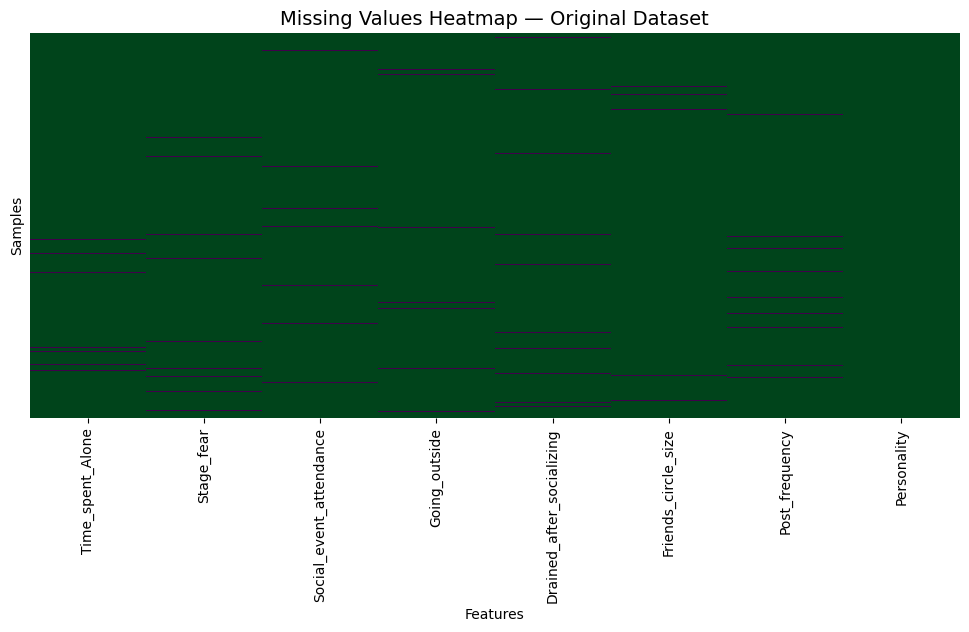

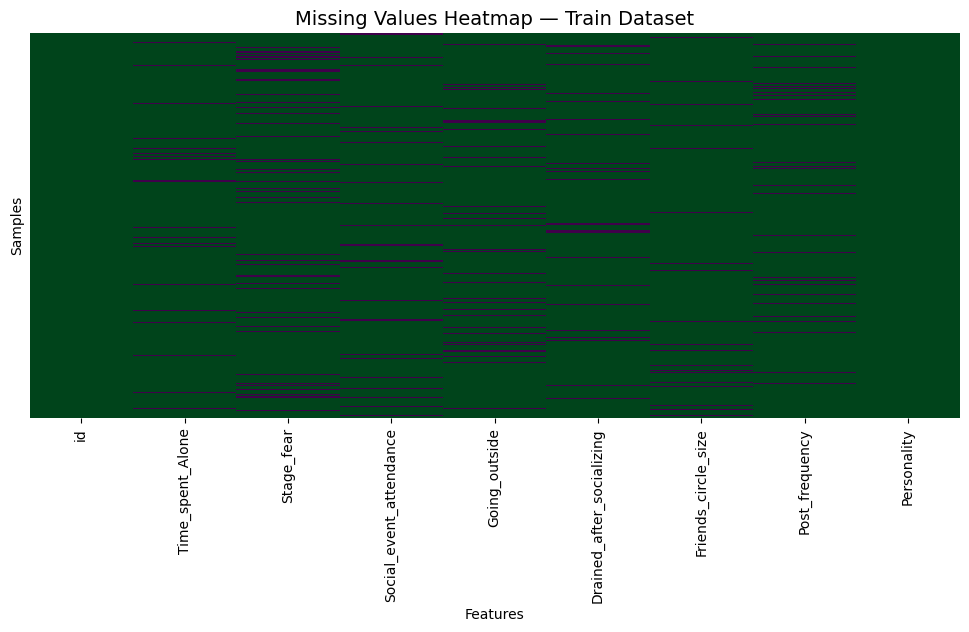

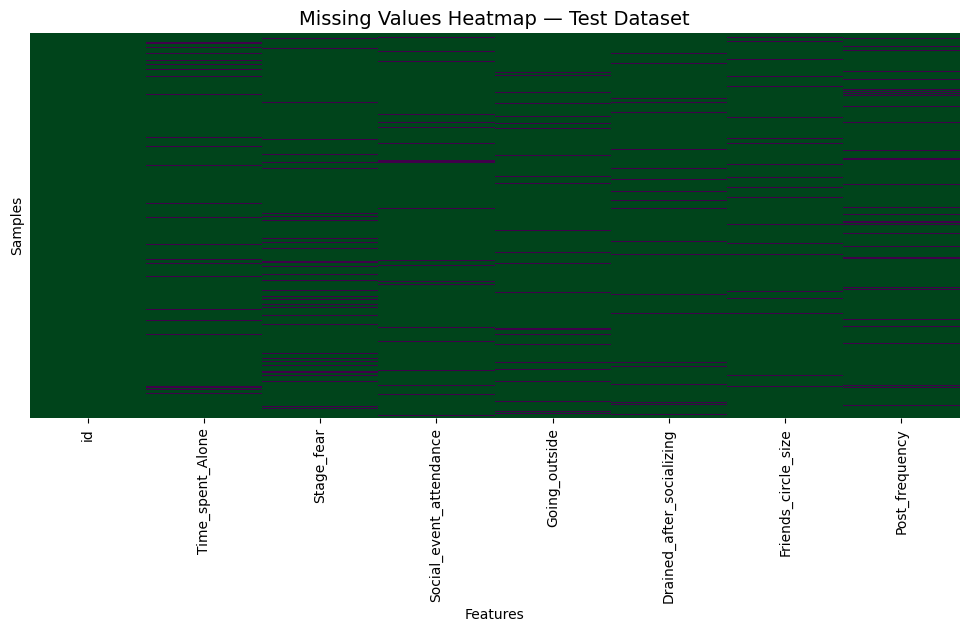

In [7]:
def plot_missing_values_heatmap(df, dataset_name="Dataset"):
    plt.figure(figsize=(12, 5))
    sns.heatmap(df.isnull(), cbar=False, cmap='PRGn_r', yticklabels=False)
    plt.title(f"Missing Values Heatmap — {dataset_name}", fontsize=14)
    plt.xlabel("Features")
    plt.ylabel("Samples")
    plt.show()

plot_missing_values_heatmap(original_data, "Original Dataset")
plot_missing_values_heatmap(train_data, "Train Dataset")
plot_missing_values_heatmap(test_data, "Test Dataset")


- The **original dataset** is relatively clean with minimal missing values.
- The **train dataset** has notable missing data:
  - `Stage_fear` and `Drained_after_socializing` show more missing values.
  - Other numerical features also have moderate levels of nulls.
- The **test dataset** mirrors the missing value patterns seen in the train set.

In [8]:
def missing_values_summary(df, dataset_name="Dataset"):
    missing_count = df.isnull().sum()
    missing_pct = 100 * missing_count / len(df)
    data_types = df.dtypes
    summary_df = pd.DataFrame({
        "Missing Count": missing_count,
        "Missing %": missing_pct.round(2),
        "Dtype": data_types
    }).sort_values(by="Missing %", ascending=False)
    
    print(f"\n{'='*60}")
    print(f"🔍 Missing Values Report — {dataset_name}")
    print(f"{'='*60}")
    print(f"Total missing values: {missing_count.sum()}\n")
    display(summary_df)
    return summary_df

def check_duplicates(df, dataset_name="Dataset"):
    dup_count = df.duplicated().sum()
    print(f"\n{'='*60}")
    print(f"🧬 Duplicate Rows Report — {dataset_name}")
    print(f"{'='*60}")
    print(f"Total duplicate rows: {dup_count}")
    if dup_count > 0:
        print(f"Showing sample duplicates:")
        display(df[df.duplicated()].head())
    return dup_count

train_missing_summary = missing_values_summary(train_data, "Train Dataset")
train_duplicates = check_duplicates(train_data, "Train Dataset")

test_missing_summary = missing_values_summary(test_data, "Test Dataset")
test_duplicates = check_duplicates(test_data, "Test Dataset")

original_missing_summary = missing_values_summary(original_data, "Original Dataset")
original_duplicates = check_duplicates(original_data, "Original Dataset")



🔍 Missing Values Report — Train Dataset
Total missing values: 9196



,Missing Count,Missing %,Dtype
Stage_fear,1893,10.22,object
Going_outside,1466,7.91,float64
Post_frequency,1264,6.82,float64
Time_spent_Alone,1190,6.42,float64
Social_event_attendance,1180,6.37,float64
Drained_after_socializing,1149,6.20,object
Friends_circle_size,1054,5.69,float64
id,0,0.00,int64
Personality,0,0.00,object



🧬 Duplicate Rows Report — Train Dataset
Total duplicate rows: 0

🔍 Missing Values Report — Test Dataset
Total missing values: 3076



,Missing Count,Missing %,Dtype
Stage_fear,598,9.68,object
Going_outside,466,7.55,float64
Drained_after_socializing,432,7.00,object
Time_spent_Alone,425,6.88,float64
Post_frequency,408,6.61,float64
Social_event_attendance,397,6.43,float64
Friends_circle_size,350,5.67,float64
id,0,0.00,int64



🧬 Duplicate Rows Report — Test Dataset
Total duplicate rows: 0

🔍 Missing Values Report — Original Dataset
Total missing values: 458



,Missing Count,Missing %,Dtype
Friends_circle_size,77,2.66,float64
Stage_fear,73,2.52,object
Going_outside,66,2.28,float64
Post_frequency,65,2.24,float64
Time_spent_Alone,63,2.17,float64
Social_event_attendance,62,2.14,float64
Drained_after_socializing,52,1.79,object
Personality,0,0.00,object



🧬 Duplicate Rows Report — Original Dataset
Total duplicate rows: 388
Showing sample duplicates:


,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
47,10.0,Yes,1.0,2.0,Yes,2.0,0.0,Introvert
217,5.0,Yes,2.0,0.0,Yes,2.0,0.0,Introvert
246,9.0,Yes,0.0,1.0,Yes,2.0,1.0,Introvert
248,9.0,Yes,0.0,2.0,Yes,3.0,2.0,Introvert
254,7.0,Yes,0.0,0.0,Yes,3.0,2.0,Introvert


Understanding missing data and duplicates is crucial for preparing robust machine learning models. Below are key insights from our analysis across the `Train`, `Test`, and `Original` datasets.

#### Missing Values Overview

| Dataset  | Total Missing Values | Notable Features with Missing Data (Count / %)              |
|----------|----------------------|-------------------------------------------------------------|
| **Train** | 9,196                | `Stage_fear` (1,893 / 10.22%), `Going_outside` (1,466 / 7.91%), `Post_frequency` (1,264 / 6.82%), and others with 5-7% missing |
| **Test**  | 3,076                | `Stage_fear` (598 / 9.68%), `Going_outside` (466 / 7.55%), `Drained_after_socializing` (432 / 7.00%) among others |
| **Original** | 458                 | Missingness is lower, around 2-3% per feature, but present in all columns except target `Personality` |

- The **train** and **test** sets exhibit substantial missingness (5-10%) across key behavioral features, highlighting the need for effective imputation strategies.
- The **original** dataset has lower missing percentages but still requires cleaning.
- Importantly, the target variable `Personality` in both train and original datasets is **complete without missing values**, which simplifies supervised learning.

#### Duplicate Data Analysis

| Dataset  | Number of Duplicate Rows |
|----------|--------------------------|
| **Train** | 0                        |
| **Test**  | 0                        |
| **Original** | 388                    |

- Both the **train** and **test** datasets are free from duplicate rows, indicating well-prepared data for modeling.
- The **original** dataset contains a significant number of duplicates (~388 rows), which may indicate repeated samples or data collection redundancies.
- These duplicates should be carefully considered, removing or consolidating them could improve model quality if the original dataset is used for training or augmentation.



*Missing data is present and non-negligible in all datasets, especially in critical behavioral features like `Stage_fear` and `Going_outside`. Addressing this will be vital in preprocessing. Duplicate rows do not affect the main datasets (`train` and `test`) but are notable in the `original` dataset. This factor should be considered when merging or augmenting datasets. The completeness of the target variable ensures a reliable basis for supervised model training.*



# <span style="color:transparent;">Exploratory Data Analysis (EDA)</span>

<div style="border-radius: 15px; border: 2px solid #6A1B9A; padding: 10px; background: linear-gradient(135deg, #9C27B0, #4CAF50); text-align: center; box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.5);">
    <h1 style="color: #ffffff; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7); font-weight: bold; margin-bottom: 5px; font-size: 28px; font-family: 'Roboto', sans-serif;">
        Exploratory Data Analysis (EDA)
    </h1>
</div>

<!-- Include Google Fonts for a modern font -->
<link href="https://fonts.googleapis.com/css2?family=Roboto:wght@700&display=swap" rel="stylesheet">


## Distribution of Personality Types

In [9]:
target_variable = 'Personality'

print(f"Target variable: {target_variable}")
print(f"Data type: {train_data[target_variable].dtype}")

Target variable: Personality
Data type: object


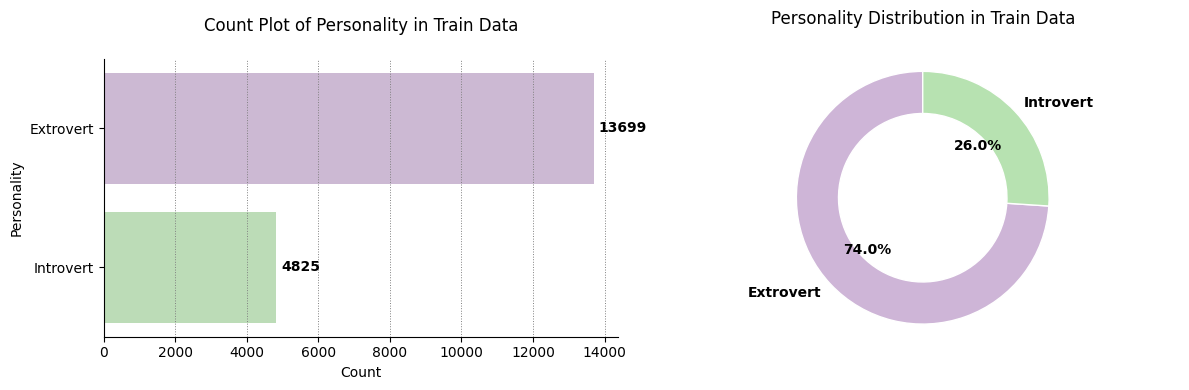

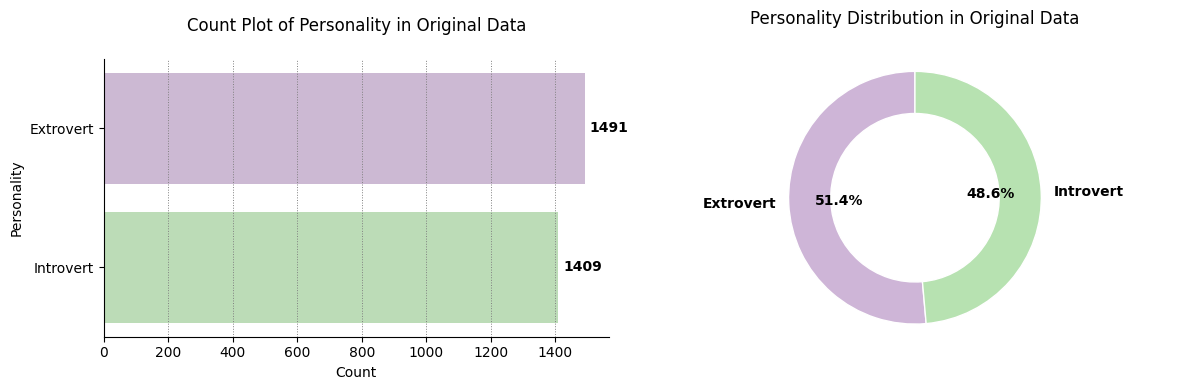

In [10]:
def plot_target_distribution(data, dataset_name, target_variable='Personality', palette_name='PRGn'):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    ax = axes[0]
    sns.countplot(y=target_variable, data=data, ax=ax, palette=palette_name)
    ax.set_title(f'Count Plot of {target_variable} in {dataset_name}', pad=20)
    ax.set_ylabel(target_variable)
    ax.set_xlabel('Count')
    ax.grid(axis='x', color='gray', linestyle=':', linewidth=0.7)
    sns.despine(ax=ax, top=True, right=True, left=False, bottom=False)

    max_count = data[target_variable].value_counts().max()
    for p in ax.patches:
        width = p.get_width()
        y = p.get_y() + p.get_height() / 2
        ax.text(width + max_count * 0.01, y,
                f'{int(width)}',
                ha='left', va='center', fontsize=10, fontweight='bold', color='black')

    ax = axes[1]
    counts = data[target_variable].value_counts().sort_index()
    wedges, texts, autotexts = ax.pie(
        counts,
        labels=counts.index,
        autopct='%1.1f%%',
        startangle=90,
        colors=sns.color_palette(palette_name, len(counts)),
        wedgeprops=dict(width=0.4, edgecolor='w'),
        radius=1.2
    )
    for text in texts + autotexts:
        text.set_fontsize(10)
        text.set_fontweight('bold')

    centre_circle = plt.Circle((0, 0), 0.70, fc='white')
    ax.add_artist(centre_circle)
    ax.set_title(f'{target_variable} Distribution in {dataset_name}', pad=25)
    ax.axis('equal')

    plt.tight_layout()
    plt.show()

plot_target_distribution(train_data, 'Train Data')
plot_target_distribution(original_data, 'Original Data')


We visualized the distribution of personality types using both count plots and donut charts.

#### Target Distribution Insights: Train vs. Original Data

- **Original Dataset:**  
  - The personality classes are nearly balanced, with **Extroverts** making up **51.4%** (1,491 samples) and **Introverts** accounting for **48.6%** (1,409 samples).
  - This balanced distribution provides a fair representation of both personality types, which is ideal for unbiased model training and evaluation.

- **Train Dataset:**  
  - There is a significant class imbalance: **Extroverts** comprise **74.0%** (13,699 samples), while **Introverts** represent only **26.0%** (4,825 samples).
  - This skew toward extroverts suggests the training data is not representative of the original population, which could lead to a model biased toward predicting the majority class.

 
*The **original dataset** offers a realistic baseline for personality trait proportions, while the **train dataset** is heavily weighted toward extroverts.
This imbalance in the train set may affect model performance, particularly its ability to correctly identify introverts.*


## Distribution Analysis of Numerical Features

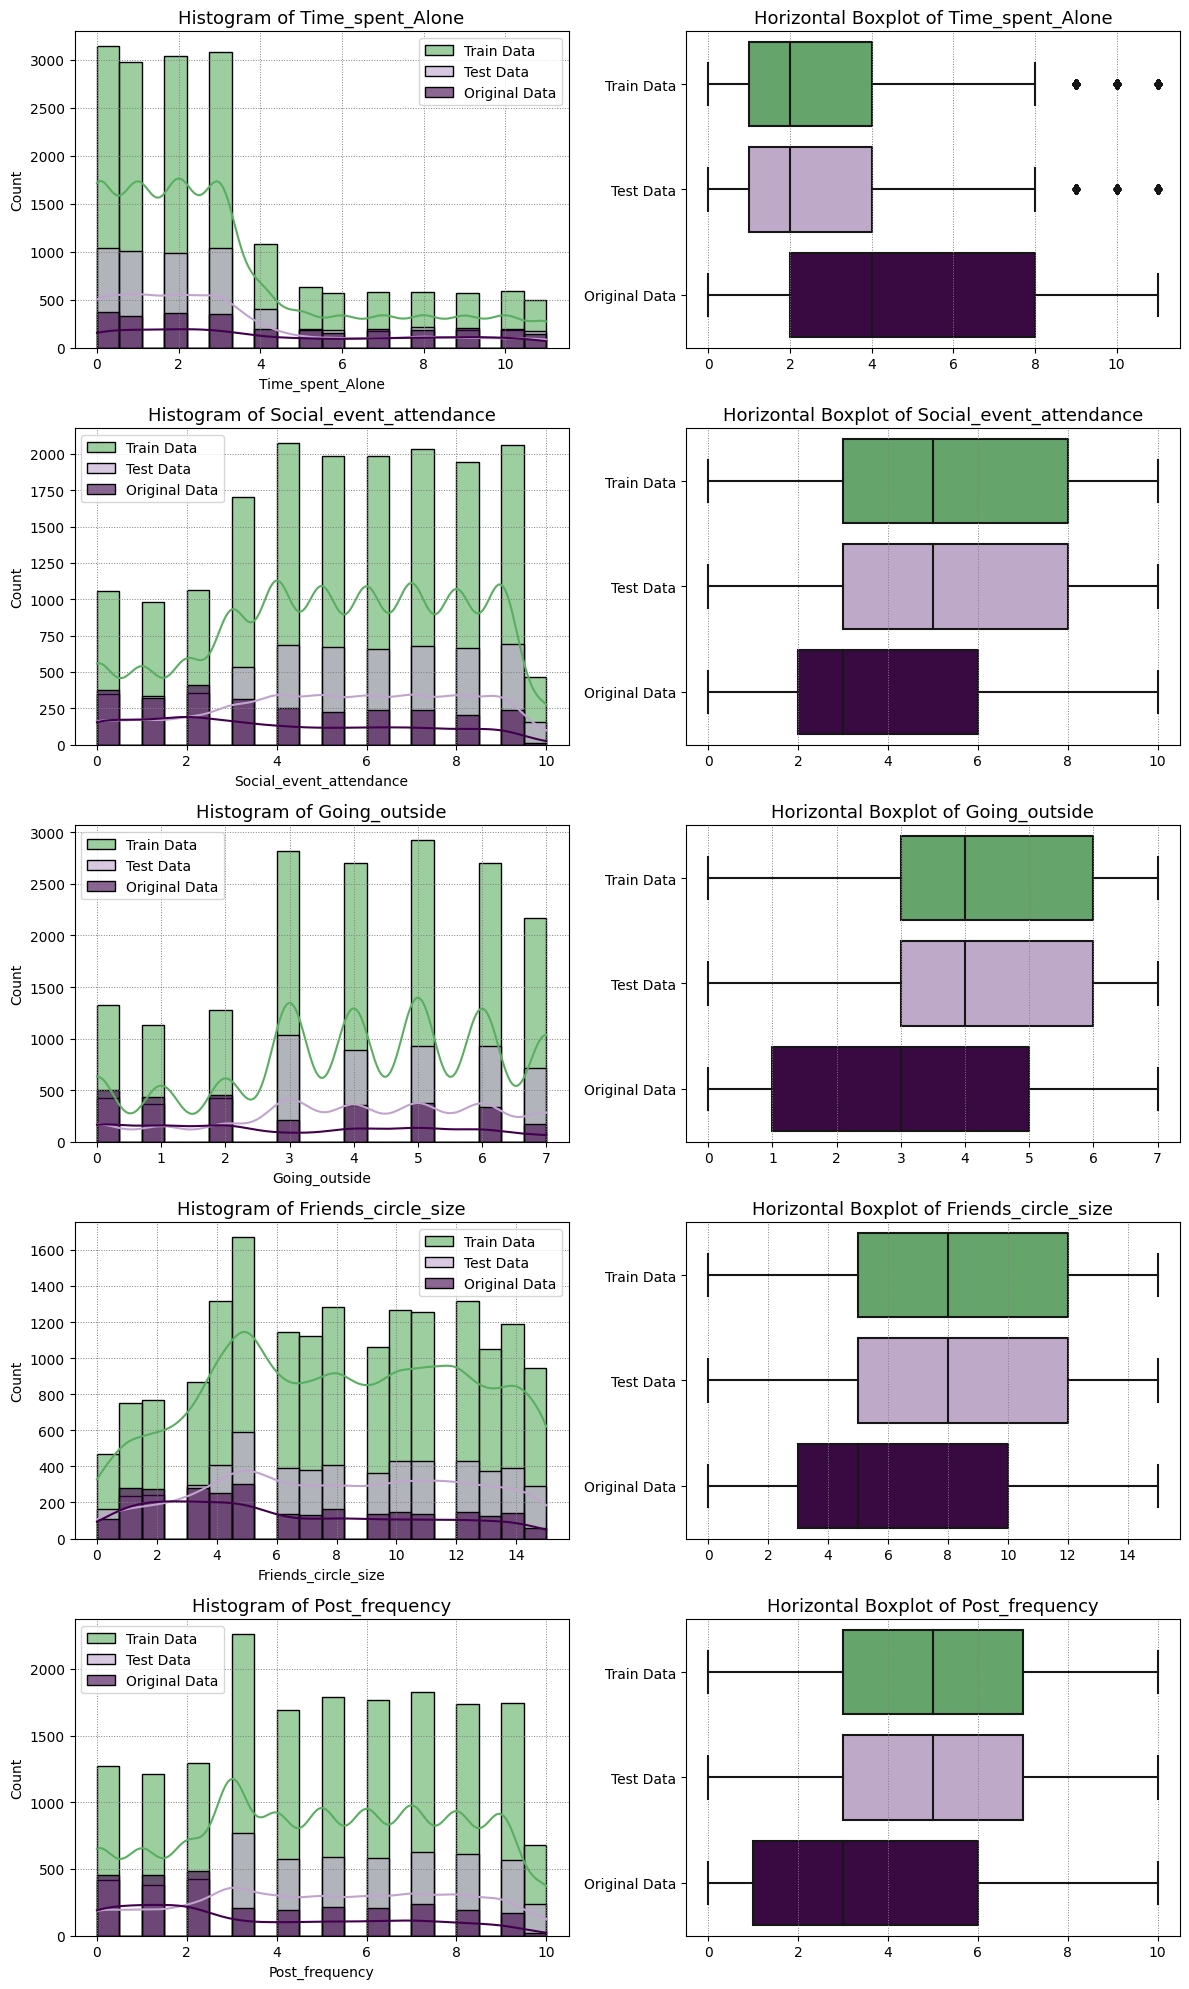

In [11]:
numerical_features = [
    'Time_spent_Alone', 'Social_event_attendance', 'Going_outside',
    'Friends_circle_size', 'Post_frequency'
]

cmap = plt.get_cmap('PRGn')
colors = [cmap(0.8), cmap(0.3), cmap(0)]

fig, axes = plt.subplots(len(numerical_features), 2, figsize=(12, len(numerical_features) * 4))

for i, feature in enumerate(numerical_features):
    sns.histplot(train_data[feature], color=colors[0], label='Train Data', bins=20, kde=True, ax=axes[i, 0], alpha=0.6)
    sns.histplot(test_data[feature], color=colors[1], label='Test Data', bins=20, kde=True, ax=axes[i, 0], alpha=0.6)
    sns.histplot(original_data[feature], color=colors[2], label='Original Data', bins=20, kde=True, ax=axes[i, 0], alpha=0.6)
    axes[i, 0].set_title(f'Histogram of {feature}', fontsize=13)
    axes[i, 0].legend()
    axes[i, 0].grid(color='gray', linestyle=':', linewidth=0.7)

    sns.boxplot(
        data=[train_data[feature].dropna(), test_data[feature].dropna(), original_data[feature].dropna()],
        palette=colors, orient='h', ax=axes[i, 1]
    )
    axes[i, 1].set_title(f'Horizontal Boxplot of {feature}', fontsize=13)
    axes[i, 1].set_yticklabels(['Train Data', 'Test Data', 'Original Data'])
    axes[i, 1].grid(axis='x', color='gray', linestyle=':', linewidth=0.7)

plt.tight_layout()
plt.show()


We compared the distributions of key behavioral features across Train, Test, and Original datasets using histograms and boxplots:

#### General Patterns and Modeling Implications 

- **Train and test datasets are consistently skewed toward more extroverted behaviors** (less time alone, more social events, larger friend circles, higher online activity) compared to the original data.
- **Original data is more balanced and representative** of a broader spectrum of personality traits.
- **Potential Risk:** Models trained on the current train set may underperform on introverted individuals or more balanced real-world data.

## Skewness Analysis

In [12]:
def check_skewness(data, dataset_name, highlight=True, sort=True):
    skew_vals = {feature: data[feature].skew(skipna=True) for feature in data.select_dtypes(include=np.number).columns}
    skew_df = pd.DataFrame.from_dict(skew_vals, orient='index', columns=['Skewness'])

    if sort:
        skew_df = skew_df.reindex(skew_df['Skewness'].abs().sort_values(ascending=False).index)

    print(f"\n📐 Skewness Summary — {dataset_name}")
    print("-"*65)
    print(f"{'Feature':<25} | {'Skewness':<10} | {'Remark'}")
    print("-"*65)

    for feature, row in skew_df.iterrows():
        skew = row['Skewness']
        abs_skew = abs(skew)
        if abs_skew > 1:
            remark = "Highly skewed"
            color = '\033[91m'
        elif abs_skew > 0.5:
            remark = "Moderately skewed"
            color = '\033[93m'
        else:
            remark = "Approximately symmetric"
            color = ''
        endc = '\033[0m' if color else ''
        if highlight and color:
            print(f"{color}{feature:<25} | {skew:>+9.4f} | {remark}{endc}")
        else:
            print(f"{feature:<25} | {skew:>+9.4f} | {remark}")
    print("-"*65)
    return skew_df

skew_train = check_skewness(train_data, "Train Dataset")
skew_test = check_skewness(test_data, "Test Dataset")
skew_original = check_skewness(original_data, "Original Dataset")



📐 Skewness Summary — Train Dataset
-----------------------------------------------------------------
Feature                   | Skewness   | Remark
-----------------------------------------------------------------
Time_spent_Alone          |   +1.1338 | Highly skewed
Going_outside             |   -0.3672 | Approximately symmetric
Social_event_attendance   |   -0.2292 | Approximately symmetric
Post_frequency            |   -0.0587 | Approximately symmetric
Friends_circle_size       |   -0.0518 | Approximately symmetric
id                        |   +0.0000 | Approximately symmetric
-----------------------------------------------------------------

📐 Skewness Summary — Test Dataset
-----------------------------------------------------------------
Feature                   | Skewness   | Remark
-----------------------------------------------------------------
Time_spent_Alone          |   +1.1535 | Highly skewed
Going_outside             |   -0.3454 | Approximately symmetric
Social_even

## Correlation Analysis of Numerical Features

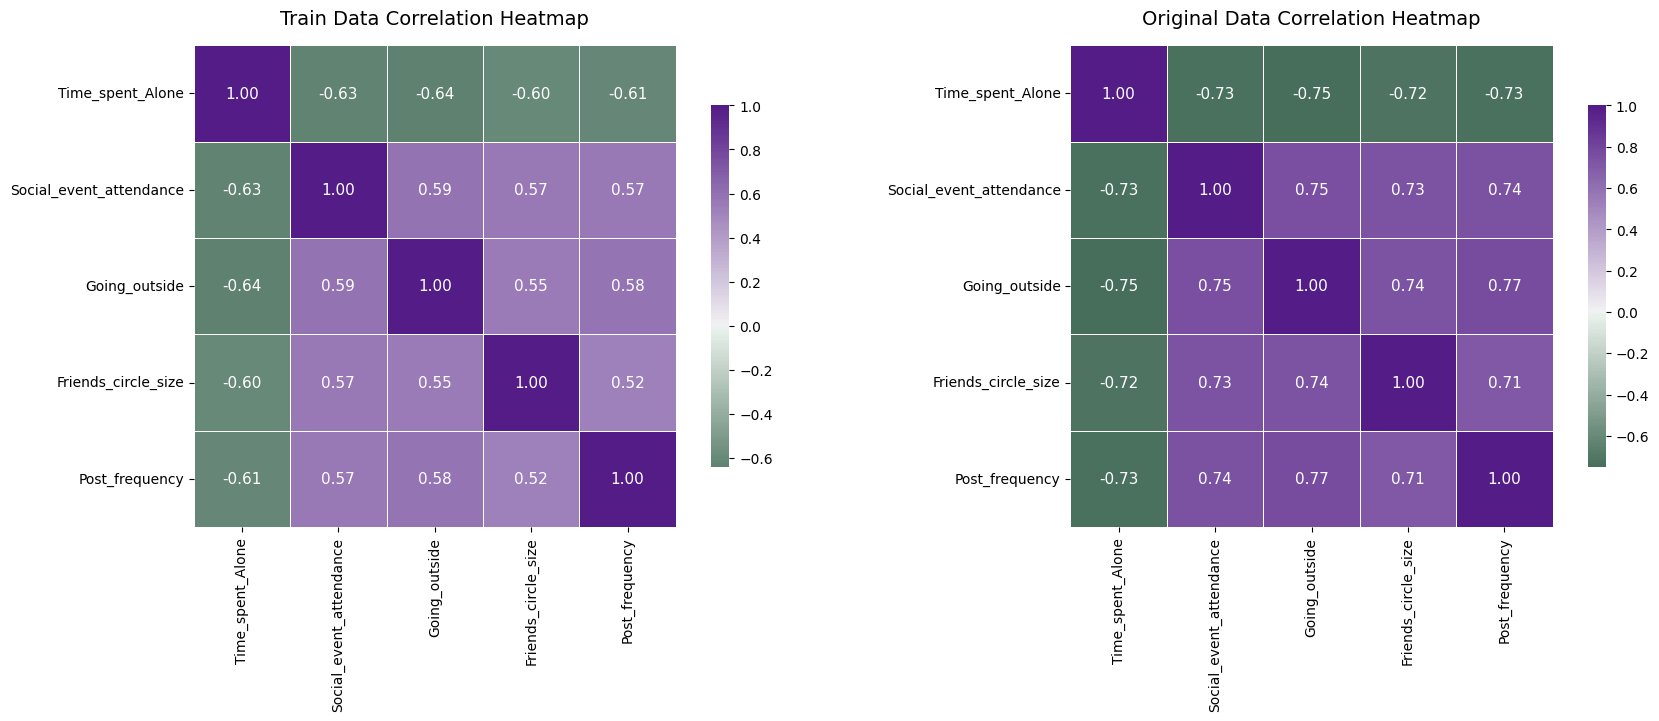

In [13]:
def plot_correlation_heatmaps(train_data, original_data, numerical_features):
    cmap = sns.diverging_palette(145, 280, s=85, l=25, as_cmap=True)
    
    corr_train = train_data[numerical_features].corr()
    corr_original = original_data[numerical_features].corr()
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    
    sns.heatmap(
        corr_train,
        annot=True,
        fmt=".2f",
        cmap=cmap,
        center=0,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.75},
        annot_kws={"size": 11},
        ax=axes[0]
    )
    axes[0].set_title('Train Data Correlation Heatmap', fontsize=14, pad=15)
    
    sns.heatmap(
        corr_original,
        annot=True,
        fmt=".2f",
        cmap=cmap,
        center=0,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.75},
        annot_kws={"size": 11},
        ax=axes[1]
    )
    axes[1].set_title('Original Data Correlation Heatmap', fontsize=14, pad=15)
    
    plt.tight_layout()
    plt.show()

plot_correlation_heatmaps(train_data, original_data, numerical_features)


To gain deeper insights into the relationships between social and behavioral attributes, we computed the **Pearson correlation matrices** for both the **Train** and **Original** datasets.

#### Correlation Heatmaps: Train vs. Original

- Both datasets reveal **strong and consistent relationships** between the behavioral features.
- Correlation patterns are **directionally similar** across datasets, though **correlation strengths are higher in the original data**.
- These results support the assumption that individual behavioral traits are interrelated, particularly within the context of social activity.

##### **Key Correlation Patterns**

##### 1. Time Spent Alone — A Distinct Inverse Indicator
- The feature `Time_spent_Alone` is **strongly negatively correlated** with all other social behavior indicators:
  - In both datasets, individuals who spend more time alone tend to:
    - Attend fewer social events,
    - Go outside less frequently,
    - Have smaller friend circles,
    - Post less often on social media.
- These negative correlations are especially pronounced in the **original dataset** (e.g., **−0.75 with `Going_outside`**), suggesting clearer personality patterns in that sample.

##### 2. Positive Clustering Among Social Activity Features
- Features like `Social_event_attendance`, `Going_outside`, `Friends_circle_size`, and `Post_frequency` show **strong positive correlations** with one another:
  - Individuals who are socially active in one domain tend to be active across others as well.
  - The highest observed correlation is **+0.77 between `Going_outside` and `Post_frequency`** in the original dataset.

##### 3. Strength Comparison: Train vs. Original
- The **Original Dataset** exhibits stronger relationships (mostly **|0.70–0.77|**), possibly due to:
  - Less missing data,
  - A more representative or noise-free sample.
- The **Train Dataset** shows **weaker but still meaningful correlations** (mostly **|0.55–0.65|**), which may be influenced by:
  - Larger sample size,
  - Higher variance and missing values.

***Predictive Power of `Time_spent_Alone`**:  Given its **strong negative correlations** with all other features, `Time_spent_Alone` is likely to be a **highly informative predictor** in distinguishing between introverts and extroverts.*


## Categorical Feature Analysis

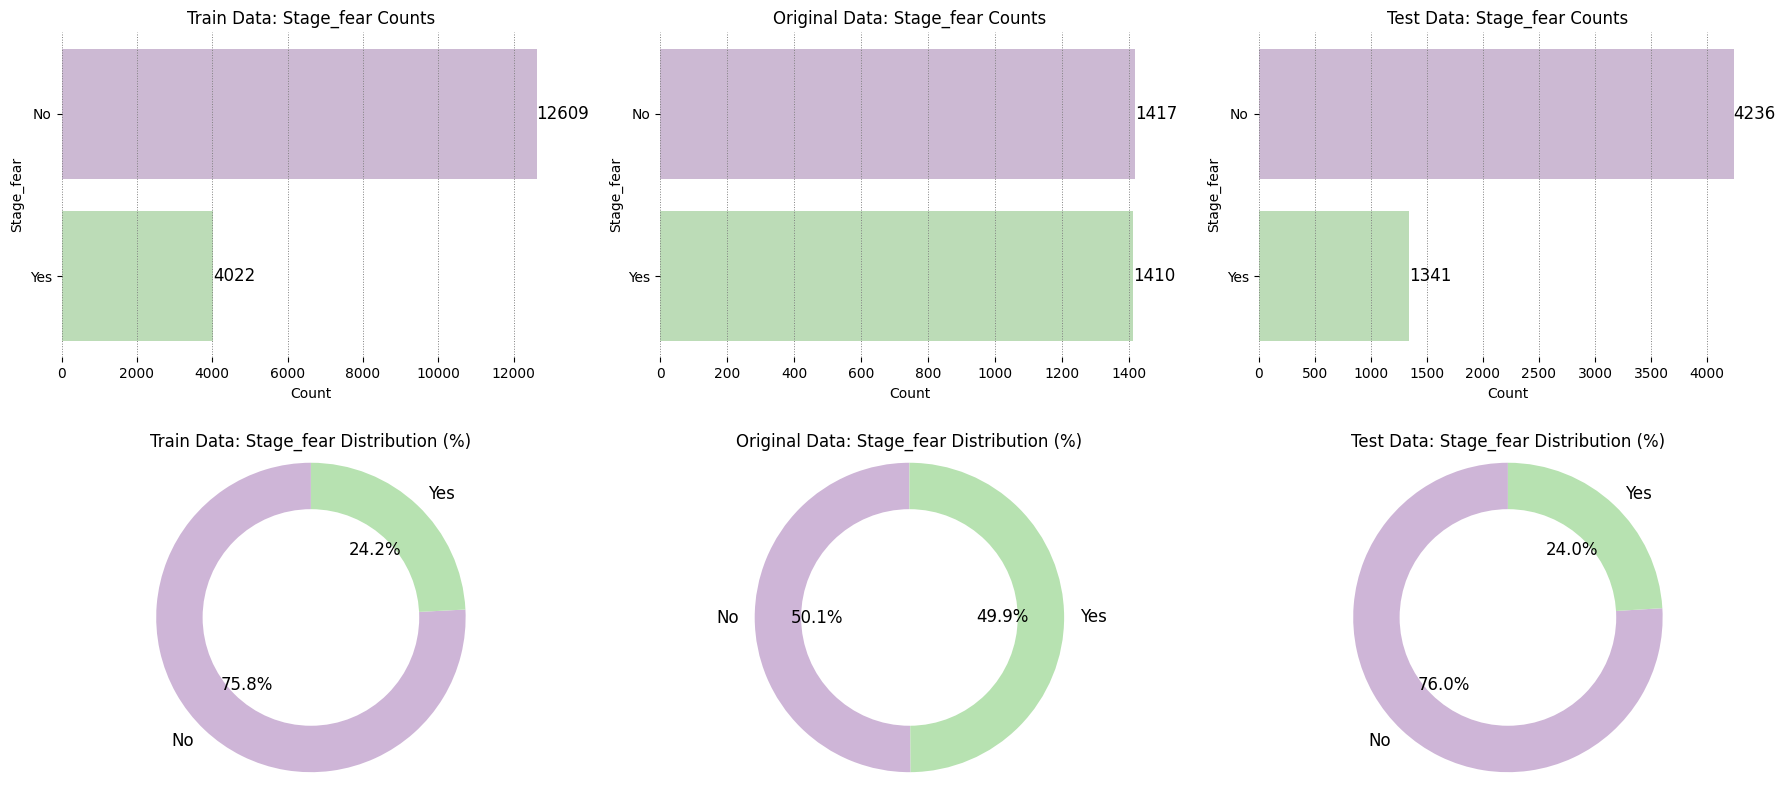

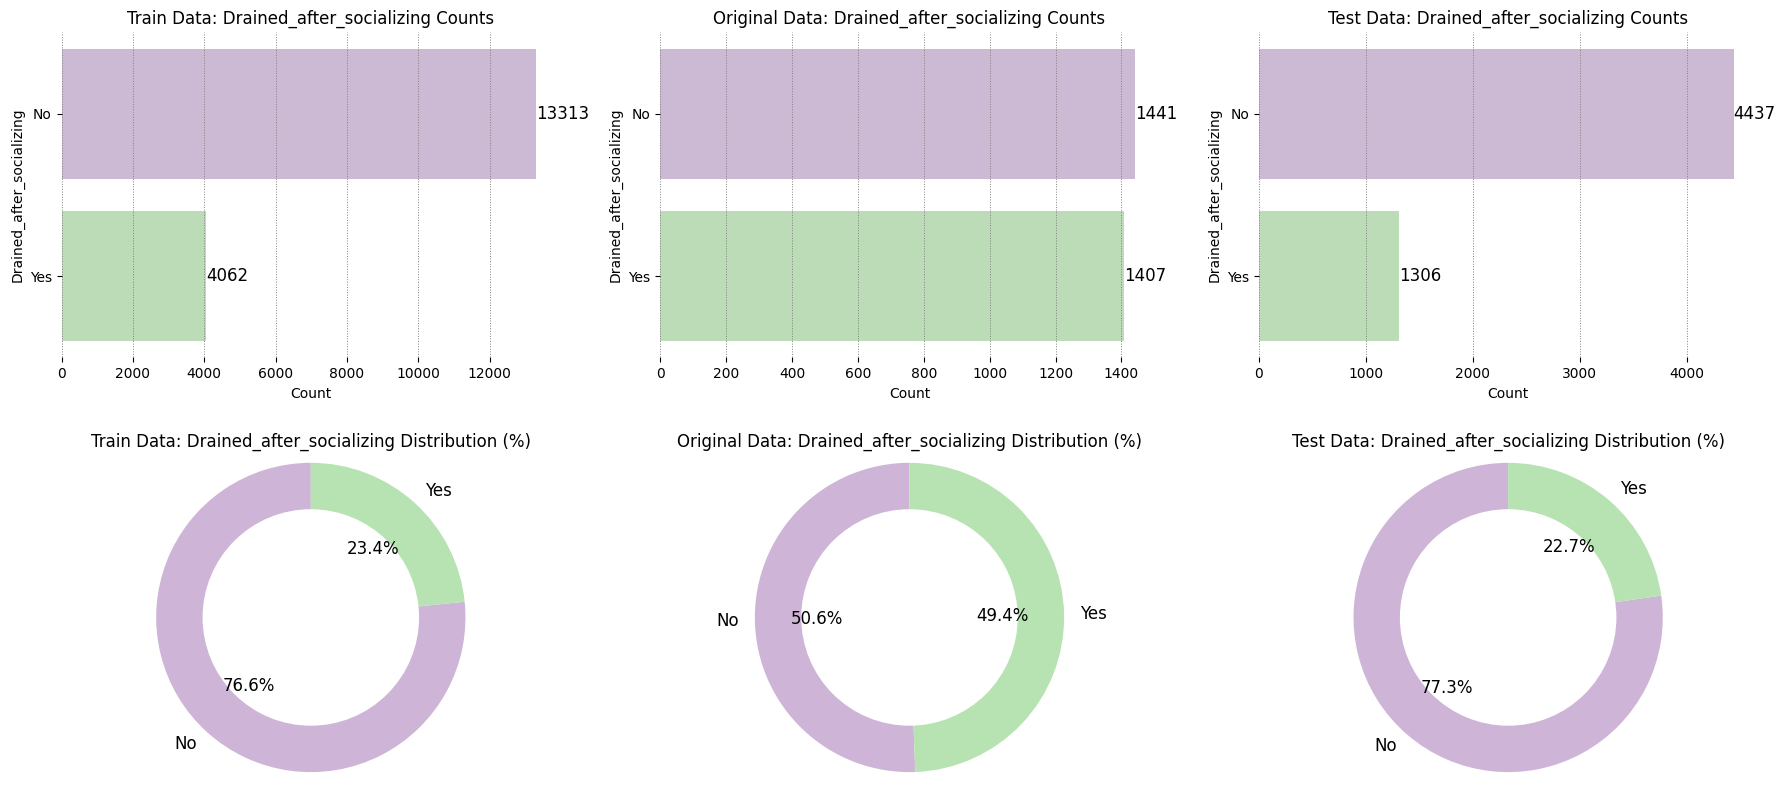

In [14]:
def plot_categorical_distribution_across_datasets(train_data, original_data, test_data, feature):
    custom_palette = sns.color_palette("PRGn", n_colors=train_data[feature].nunique())
    dataset_names = ['Train', 'Original', 'Test']
    datasets = [train_data, original_data, test_data]

    fig, axes = plt.subplots(2, 3, figsize=(18, 8))

    for i, (data, name) in enumerate(zip(datasets, dataset_names)):
        order = data[feature].value_counts().index
        sns.countplot(y=feature, data=data, ax=axes[0, i], palette=custom_palette, order=order)
        axes[0, i].set_title(f'{name} Data: {feature} Counts')
        axes[0, i].set_xlabel('Count')
        axes[0, i].set_ylabel(feature)

        for p in axes[0, i].patches:
            axes[0, i].annotate(
                f'{int(p.get_width())}',
                (p.get_width(), p.get_y() + p.get_height() / 2),
                ha='left', va='center',
                color='black', fontsize=12
            )
        axes[0, i].grid(axis='x', color='gray', linestyle=':', linewidth=0.7)
        sns.despine(left=True, bottom=True, ax=axes[0, i])

    for i, (data, name) in enumerate(zip(datasets, dataset_names)):
        counts = data[feature].value_counts()
        wedges, texts, autotexts = axes[1, i].pie(
            counts,
            labels=counts.index,
            autopct='%1.1f%%',
            startangle=90,
            colors=custom_palette,
            textprops={'fontsize': 12}
        )
        centre_circle = plt.Circle((0, 0), 0.70, fc='white')
        axes[1, i].add_artist(centre_circle)
        axes[1, i].set_title(f'{name} Data: {feature} Distribution (%)')
        axes[1, i].axis('equal')

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.3)
    plt.show()

categorical_features = ['Stage_fear', 'Drained_after_socializing']

for feature in categorical_features:
    plot_categorical_distribution_across_datasets(train_data, original_data, test_data, feature)


We explored how the distributions of two key categorical variables, **Stage_fear** and **Drained_after_socializing** differ across the **Train**, **Test**, and **Original** datasets using **bar plots and donut charts**.

#### Categorical Feature Distribution Across Datasets

##### 1. **Stage_fear**

- **Original Dataset:**  
  - The distribution of `Stage_fear` is nearly balanced, with `No` at 50.1% and `Yes` at 49.9%.
  - This suggests that in the original sample, the population is almost equally split between those who do and do not experience stage fear.

- **Train & Test Datasets:**  
  - There is a pronounced shift:  
    - In the **train set**, 75.8% answered `No` and only 24.2% answered `Yes`.
    - In the **test set**, 76.0% answered `No` and 24.0% answered `Yes`.
  - This indicates that the competition datasets are skewed towards individuals who do **not** experience stage fear.

*The synthetic (train/test) data underrepresents individuals with stage fear compared to the original data.*

##### 2. **Drained_after_socializing**

- **Original Dataset:**  
  - The distribution is again nearly even: 50.6% `No` and 49.4% `Yes`.
  - This reflects a balanced representation of people who do and do not feel drained after socializing.

- **Train & Test Datasets:**  
  - There is a similar skew as with `Stage_fear`:  
    - In the **train set**, 76.6% answered `No` and 23.4% answered `Yes`.
    - In the **test set**, 77.3% answered `No` and 22.7% answered `Yes`.
  - The majority in these datasets do **not** feel drained after socializing.

*The competition datasets are biased towards individuals who are more socially resilient (do not feel drained).*

##### 3. **General Observations**

- The **original dataset** provides a more balanced view of social anxieties and fatigue, while the **train/test datasets** are skewed towards more socially confident and resilient individuals.


## Numerical Features by Personality

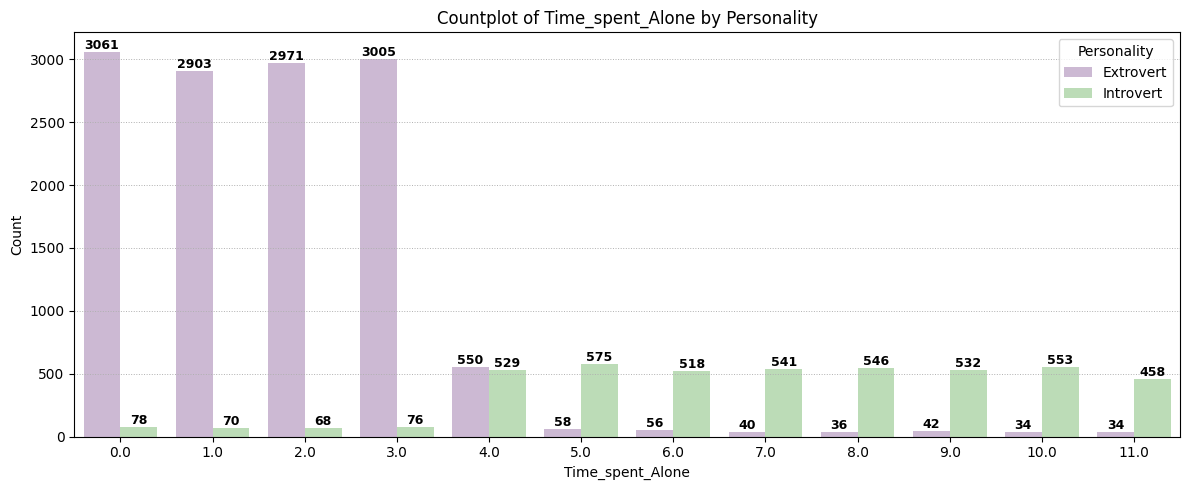

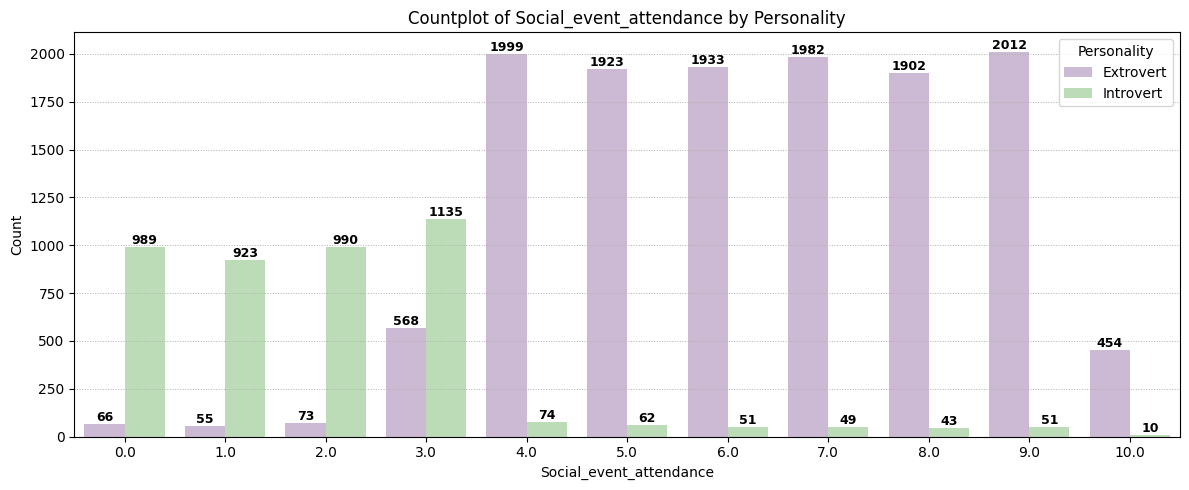

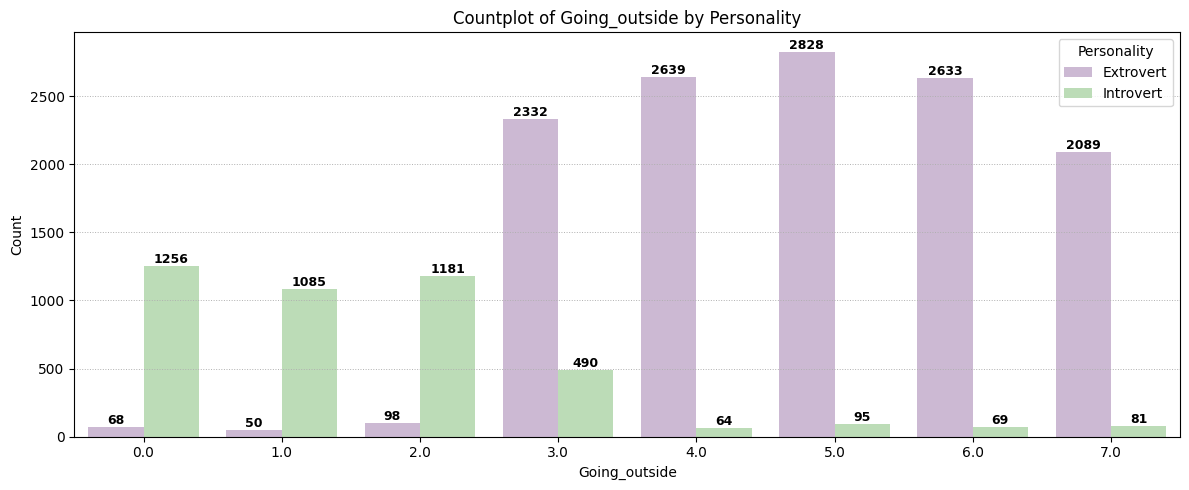

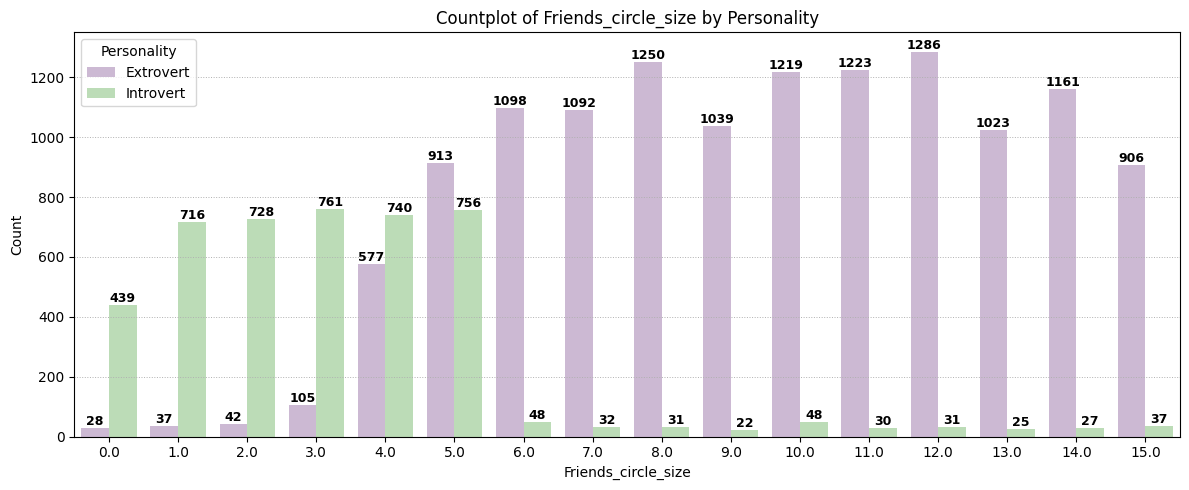

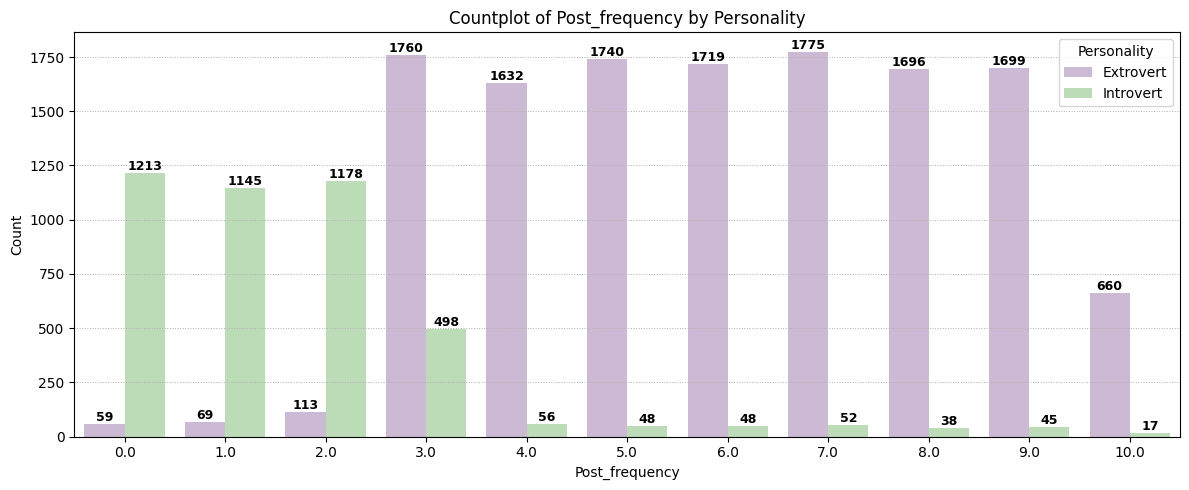

In [15]:
def plot_discrete_numerical_counts(data, numerical_features, target_variable='Personality', palette_name='PRGn', aspect=1.5):
    palette = sns.color_palette(palette_name, 2)
    
    for feature in numerical_features:
        plt.figure(figsize=(12, 5))
        ax = sns.countplot(
            data=data,
            x=feature,
            hue=target_variable,
            palette=palette
        )
        ax.set_title(f'Countplot of {feature} by {target_variable}')
        ax.set_xlabel(feature)
        ax.set_ylabel('Count')
        plt.grid(axis='y', linestyle=':', linewidth=0.7)
        
        for p in ax.patches:
            height = p.get_height()
            ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2, height),
                        ha='center', va='bottom', fontsize=9, fontweight='bold')
        
        plt.tight_layout()
        plt.show()

plot_discrete_numerical_counts(train_data, numerical_features)

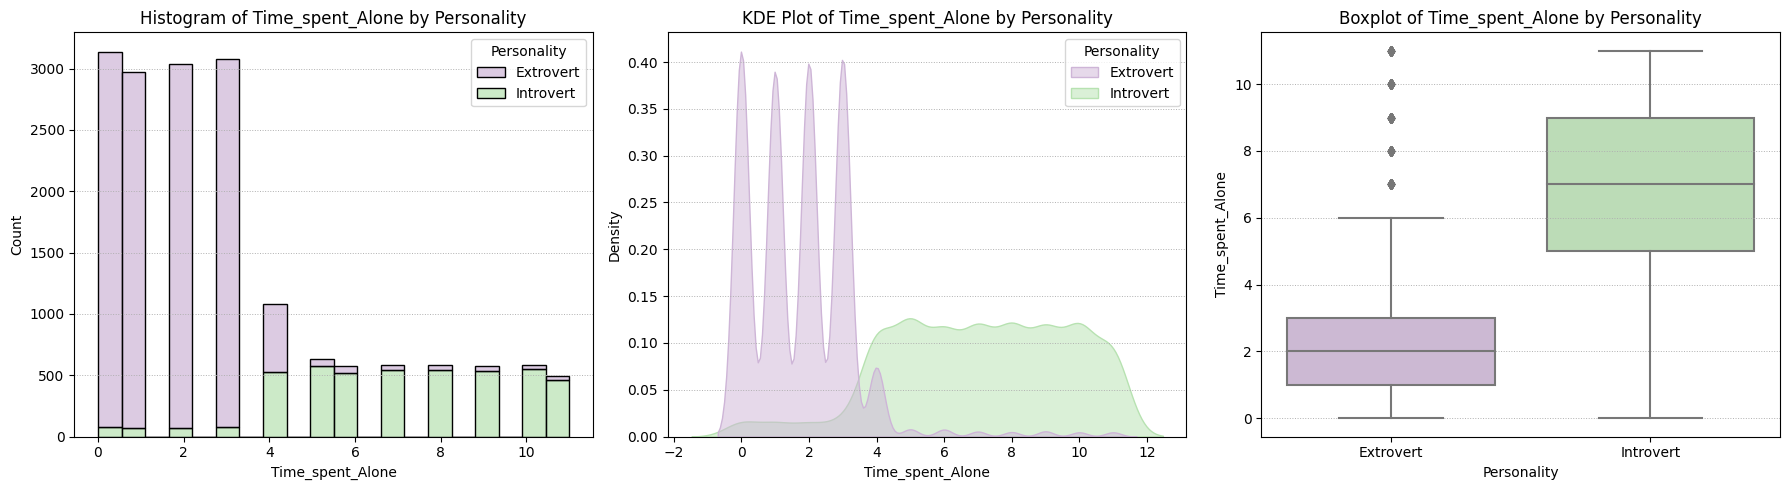


📋 Descriptive Statistics for 'Time_spent_Alone' by 'Personality'


,count,mean,std,min,25%,50%,75%,max
Personality,,,,,,,,
Extrovert,"12,790",1.747,1.538,0.0,1.0,2.0,3.0,11.0
Introvert,"4,544",7.052,2.646,0.0,5.0,7.0,9.0,11.0


------------------------------------------------------------


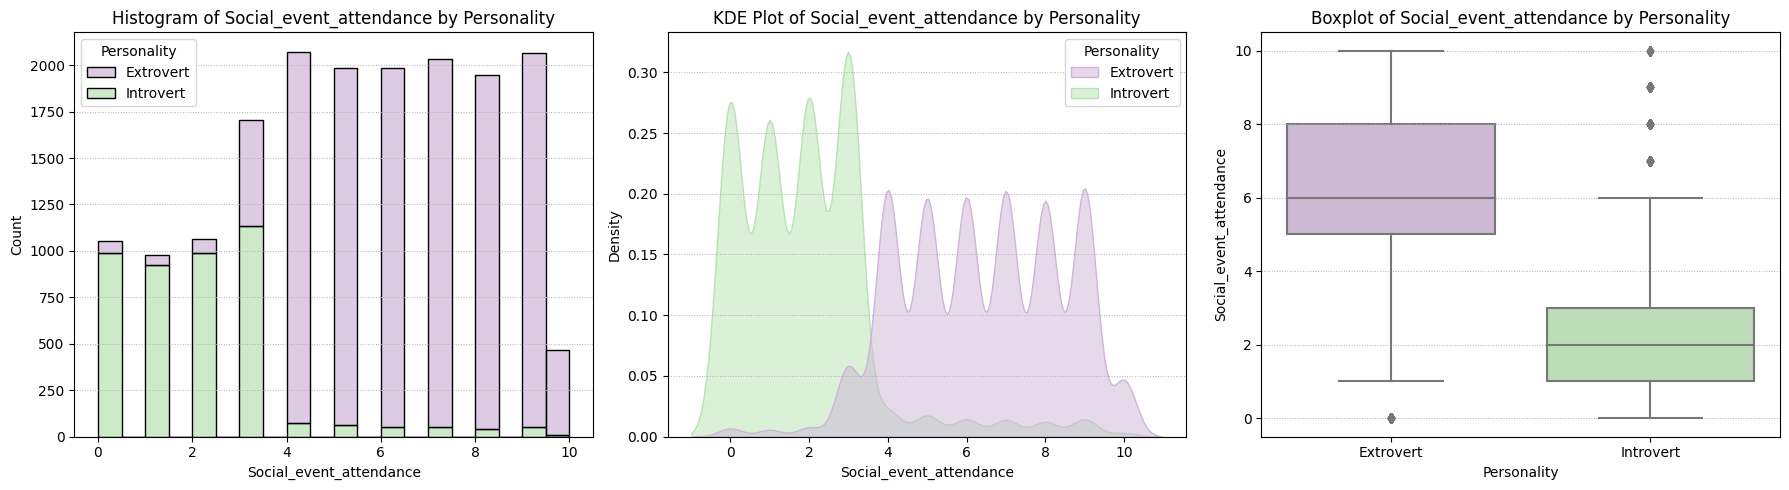


📋 Descriptive Statistics for 'Social_event_attendance' by 'Personality'


,count,mean,std,min,25%,50%,75%,max
Personality,,,,,,,,
Extrovert,"12,967",6.389,2.021,0.0,5.0,6.0,8.0,10.0
Introvert,"4,377",1.934,1.761,0.0,1.0,2.0,3.0,10.0


------------------------------------------------------------


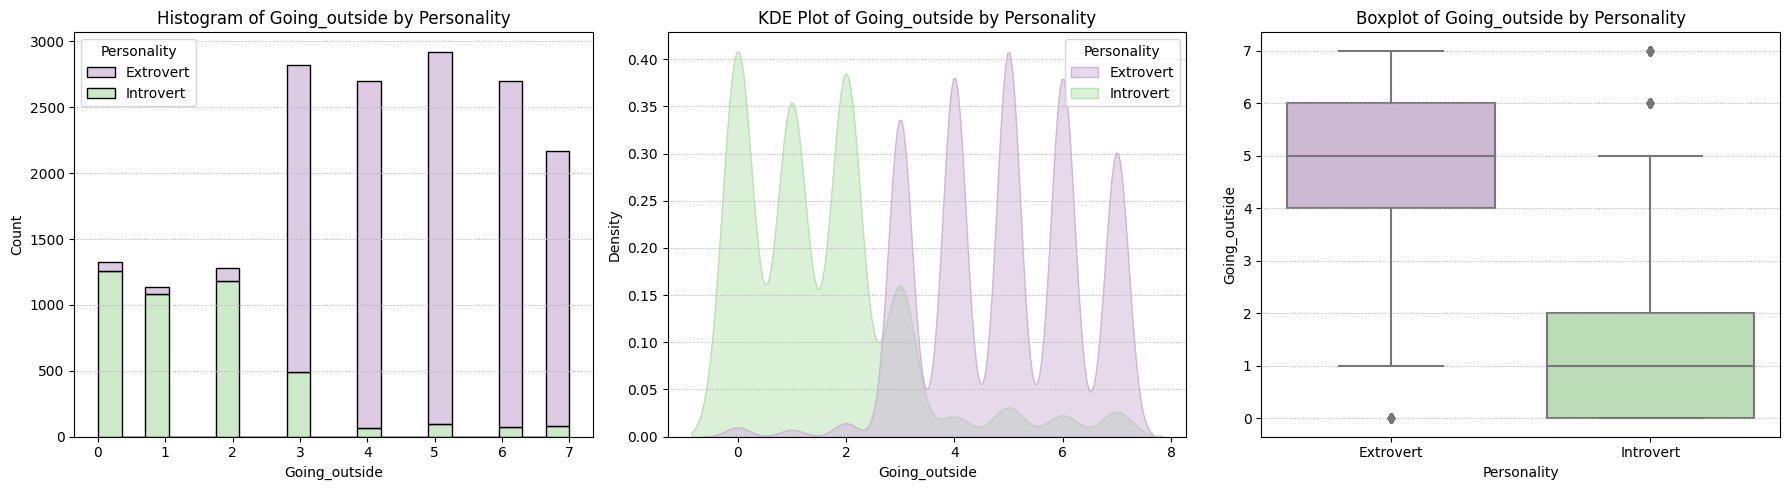


📋 Descriptive Statistics for 'Going_outside' by 'Personality'


,count,mean,std,min,25%,50%,75%,max
Personality,,,,,,,,
Extrovert,"12,737",4.896,1.434,0.0,4.0,5.0,6.0,7.0
Introvert,"4,321",1.534,1.514,0.0,0.0,1.0,2.0,7.0


------------------------------------------------------------


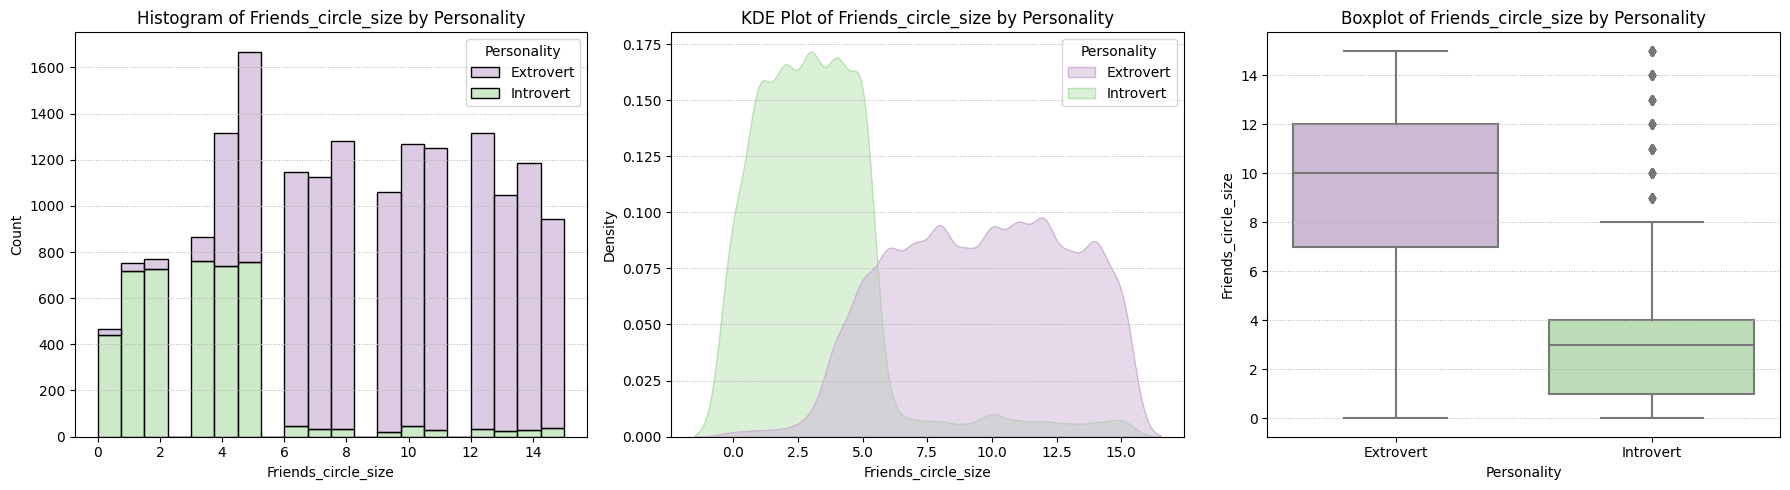


📋 Descriptive Statistics for 'Friends_circle_size' by 'Personality'


,count,mean,std,min,25%,50%,75%,max
Personality,,,,,,,,
Extrovert,"12,999",9.625,3.347,0.0,7.0,10.0,12.0,15.0
Introvert,"4,471",3.264,2.650,0.0,1.0,3.0,4.0,15.0


------------------------------------------------------------


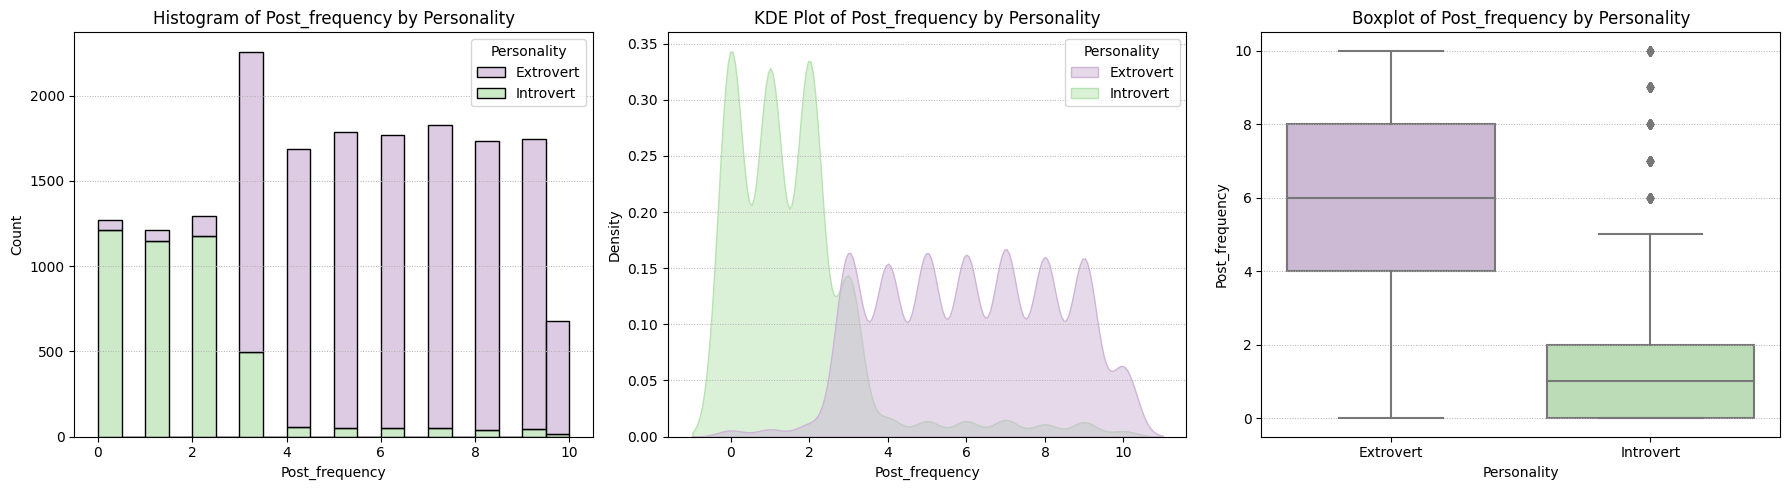


📋 Descriptive Statistics for 'Post_frequency' by 'Personality'


,count,mean,std,min,25%,50%,75%,max
Personality,,,,,,,,
Extrovert,"12,922",6.114,2.226,0.0,4.0,6.0,8.0,10.0
Introvert,"4,338",1.611,1.746,0.0,0.0,1.0,2.0,10.0


------------------------------------------------------------


In [16]:
def plot_and_describe_by_target(data, numerical_features, target_variable, palette):
    grouped = data.groupby(target_variable)
    
    for feature in numerical_features:
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        sns.histplot(
            data=data, x=feature, hue=target_variable, multiple='stack',
            bins=20, palette=palette, ax=axes[0], alpha=0.7
        )
        axes[0].set_title(f'Histogram of {feature} by {target_variable}')
        axes[0].set_xlabel(feature)
        axes[0].set_ylabel('Count')
        axes[0].grid(axis='y', linestyle=':', linewidth=0.7)
        
        sns.kdeplot(
            data=data, x=feature, hue=target_variable, palette=palette,
            fill=True, common_norm=False, alpha=0.5, ax=axes[1]
        )
        axes[1].set_title(f'KDE Plot of {feature} by {target_variable}')
        axes[1].set_xlabel(feature)
        axes[1].set_ylabel('Density')
        axes[1].grid(axis='y', linestyle=':', linewidth=0.7)
        
        sns.boxplot(
            x=target_variable, y=feature, data=data, palette=palette, ax=axes[2]
        )
        axes[2].set_title(f'Boxplot of {feature} by {target_variable}')
        axes[2].set_xlabel(target_variable)
        axes[2].set_ylabel(feature)
        axes[2].grid(axis='y', linestyle=':', linewidth=0.7)
        
        plt.tight_layout()
        plt.show()
        
        print(f"\n{'='*60}")
        print(f"📋 Descriptive Statistics for '{feature}' by '{target_variable}'")
        print(f"{'='*60}")
        
        desc = grouped[feature].describe()
        desc.loc[:, 'count'] = desc.loc[:, 'count'].map('{:,.0f}'.format)
        desc.loc[:, ['mean', 'std', 'min', '25%', '50%', '75%', 'max']] = desc.loc[:, ['mean', 'std', 'min', '25%', '50%', '75%', 'max']].round(3)
        
        display(desc)
        print("-" * 60)

palette = sns.color_palette('PRGn', 2)
plot_and_describe_by_target(train_data, numerical_features, target_variable, palette)


## Categorical Features by Personality

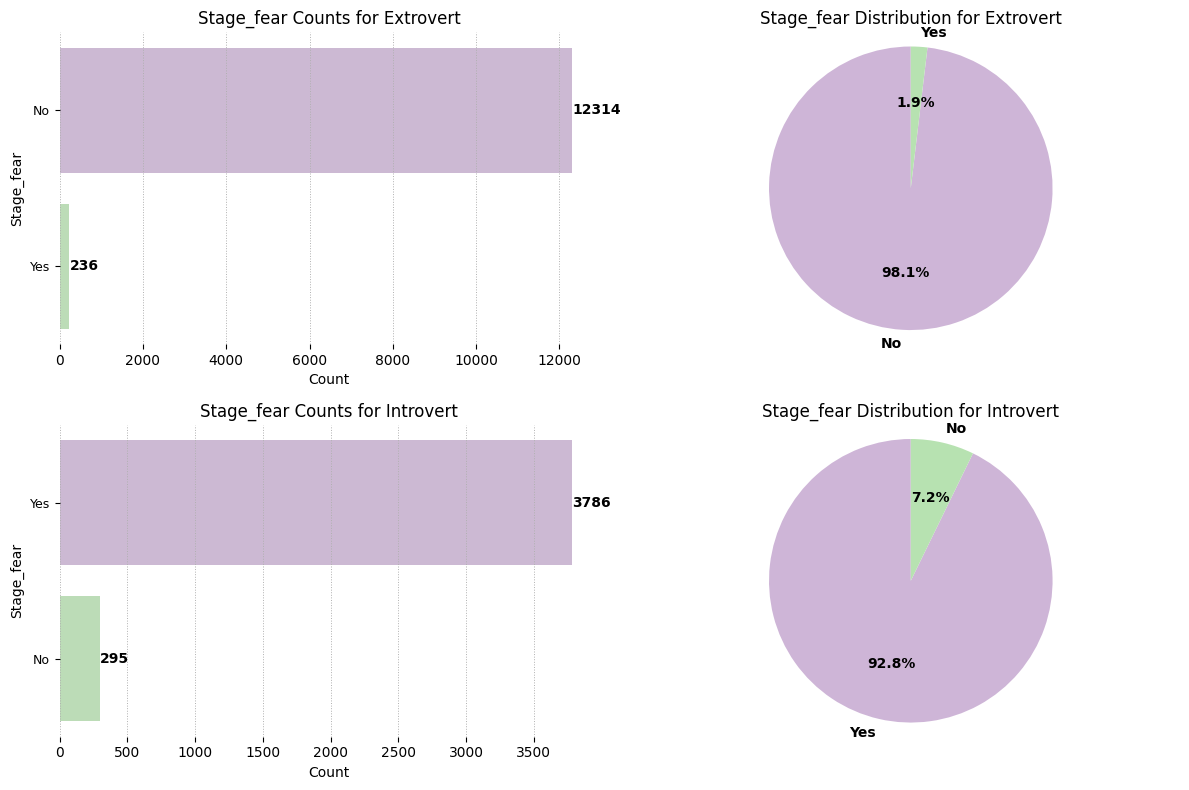

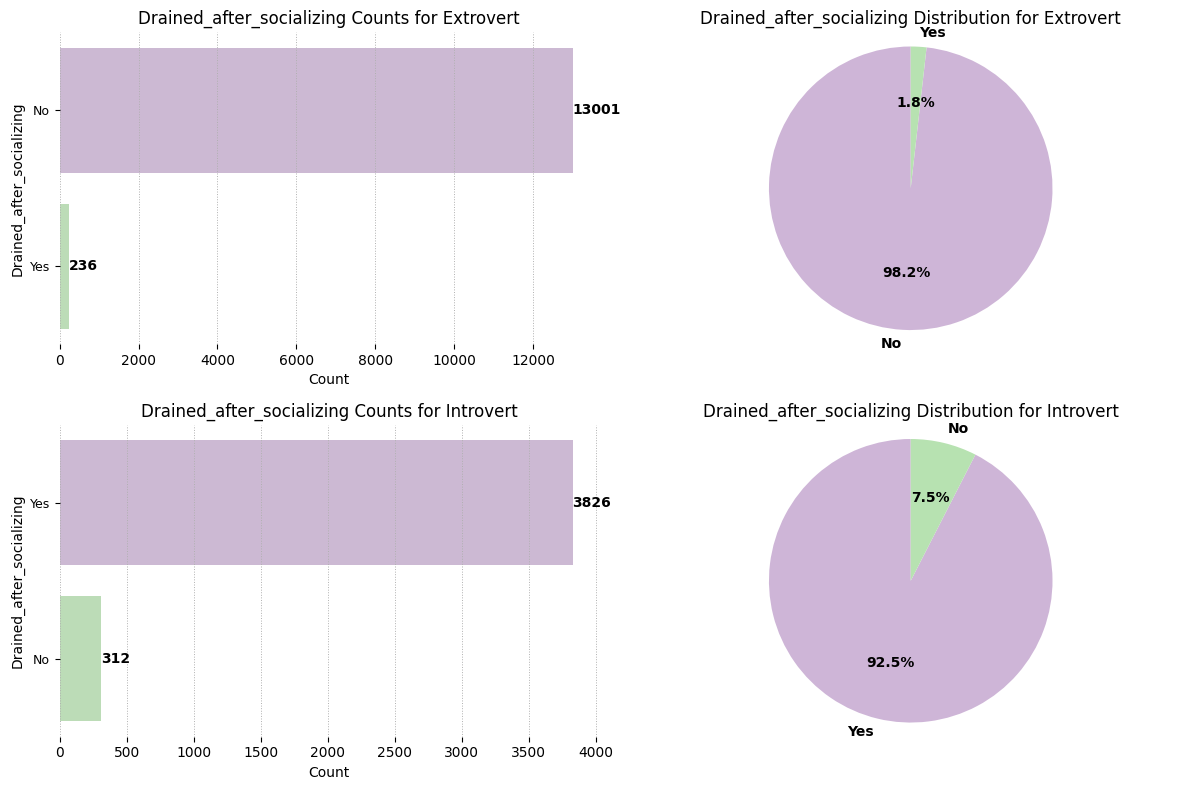

In [17]:
def plot_categorical_features_by_personality(df, categorical_features, target_variable='Personality', palette_name='PRGn'):
    palette = sns.color_palette(palette_name, 2)
    unique_personalities = df[target_variable].unique()
    num_personalities = len(unique_personalities)
    
    for feature in categorical_features:
        fig, axes = plt.subplots(num_personalities, 2, figsize=(12, 4 * num_personalities))
        
        if num_personalities == 1:
            axes = [axes]
        
        for i, personality in enumerate(unique_personalities):
            filtered_data = df[df[target_variable] == personality]
            
            sns.countplot(
                y=feature,
                data=filtered_data,
                ax=axes[i][0],
                palette=palette
            )
            axes[i][0].set_title(f'{feature} Counts for {personality}')
            axes[i][0].set_xlabel('Count')
            axes[i][0].set_ylabel(feature)
            axes[i][0].tick_params(axis='y', labelsize=9)
            
            for p in axes[i][0].patches:
                axes[i][0].annotate(
                    f'{int(p.get_width())}',
                    (p.get_width(), p.get_y() + p.get_height() / 2),
                    ha='left', va='center',
                    fontsize=10,
                    fontweight='bold',
                    color='black'
                )
            axes[i][0].grid(axis='x', linestyle=':', linewidth=0.7)
            sns.despine(left=True, bottom=True, ax=axes[i][0])
            
            counts = filtered_data[feature].value_counts()
            wedges, texts, autotexts = axes[i][1].pie(
                counts,
                labels=counts.index,
                autopct='%1.1f%%',
                startangle=90,
                colors=palette
            )
            axes[i][1].set_title(f'{feature} Distribution for {personality}')
            axes[i][1].axis('equal')
            
            for text in texts + autotexts:
                text.set_fontsize(10)
                text.set_fontweight('bold')
        
        plt.tight_layout()
        plt.show()

plot_categorical_features_by_personality(train_data, categorical_features)


To uncover patterns between behavioral traits and personality types (Introvert vs. Extrovert), we analyzed the distribution of **numerical** and **categorical** features grouped by the target variable `Personality`.

#### Numerical Features by Personality

The descriptive statistics show **strong contrast** between Introverts and Extroverts across all numeric features:

| Feature                | Extroverts (Mean ± Std) | Introverts (Mean ± Std) | Key Insights |
|------------------------|--------------------------|---------------------------|--------------|
| **Time_spent_Alone**   | 1.75 ± 1.54              | 7.05 ± 2.65               | Introverts spend significantly more time alone. |
| **Social_event_attendance** | 6.39 ± 2.02         | 1.93 ± 1.76               | Extroverts frequently attend social events, while Introverts rarely do. |
| **Going_outside**      | 4.90 ± 1.43              | 1.53 ± 1.51               | Extroverts go outside much more often. |
| **Friends_circle_size**| 9.63 ± 3.35              | 3.26 ± 2.65               | Extroverts have larger friend circles. |
| **Post_frequency**     | 6.11 ± 2.23              | 1.61 ± 1.75               | Extroverts post more frequently on social platforms. |

* These differences confirm expected psychological patterns, extroverts display higher social engagement, while introverts prefer solitude and lower external stimulation.

#### Categorical Features by Personality

We examined the distribution of binary behavioral features (`Yes`/`No`) across personality groups.

##### Stage_fear

| Personality | No     | Yes    | % No   | % Yes  |
|-------------|--------|--------|--------|--------|
| Extrovert   | 12,314 | 236    | 98.1%  | 1.9%   |
| Introvert   | 295    | 3,786  | 7.2%   | 92.8%  |

* Most extroverts **do not** have stage fear, while **over 90%** of introverts experience it.

##### Drained_after_socializing

| Personality | No     | Yes    | % No   | % Yes  |
|-------------|--------|--------|--------|--------|
| Extrovert   | 13,001 | 236    | 98.2%  | 1.8%   |
| Introvert   | 312    | 3,826  | 7.5%   | 92.5%  |

* Extroverts are **energized** by social interactions, whereas introverts often feel **drained**.


*All **numerical features** show clear separation between personality types, supporting strong predictive potential. Binary behavioral indicators like `Stage_fear` and `Drained_after_socializing` exhibit extreme polarity, further strengthening their value for classification. These findings validate both psychological theory and the dataset's quality, suggesting that feature selection and modeling should heavily leverage these traits.*


## Is Missingness Informative? Personality-Wise Missing Value Analysis


🔍 Missing Value Analysis by Personality — Train Dataset

📋 Missing Percentage Summary Table:



Personality,Extrovert % Missing,Introvert % Missing,Difference (Ext - Intro)
Time_spent_Alone,6.64,5.82,0.82
Stage_fear,8.39,15.42,-7.03
Social_event_attendance,5.34,9.28,-3.94
Going_outside,7.02,10.45,-3.43
Drained_after_socializing,3.37,14.24,-10.87
Friends_circle_size,5.11,7.34,-2.23
Post_frequency,5.67,10.09,-4.42


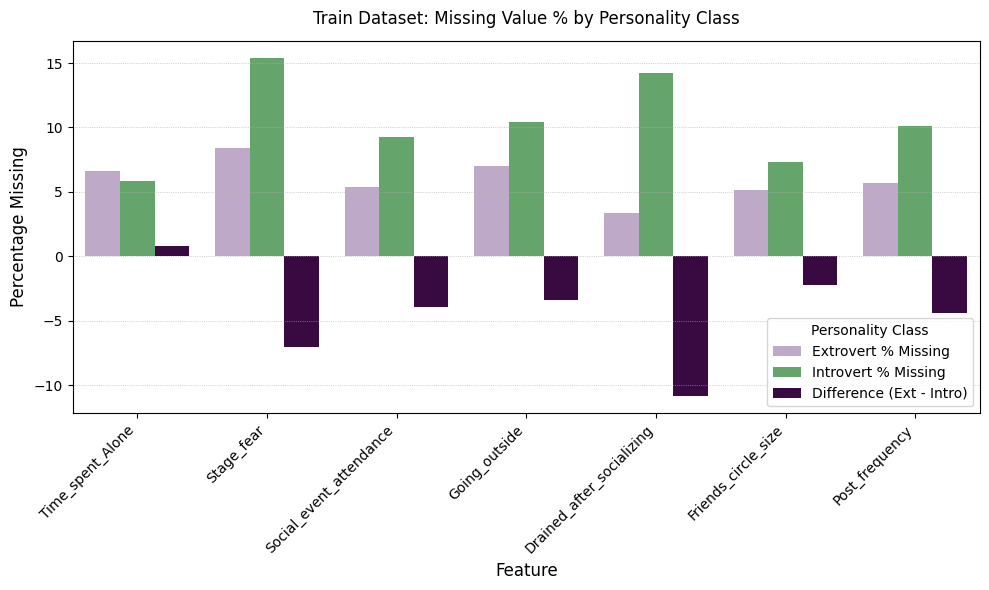


🔍 Missing Value Analysis by Personality — Original Dataset

📋 Missing Percentage Summary Table:



Personality,Extrovert % Missing,Introvert % Missing,Difference (Ext - Intro)
Time_spent_Alone,2.28,2.06,0.22
Stage_fear,2.82,2.20,0.62
Social_event_attendance,1.88,2.41,-0.53
Going_outside,2.35,2.20,0.15
Drained_after_socializing,1.21,2.41,-1.20
Friends_circle_size,2.68,2.63,0.05
Post_frequency,2.21,2.27,-0.06


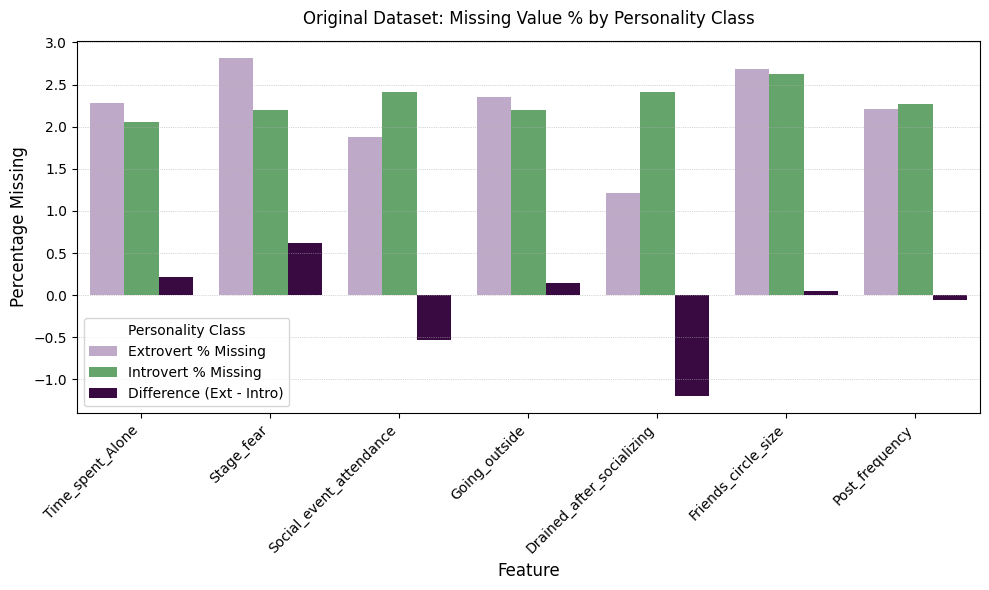

In [18]:
def analyze_missing_by_personality_dynamic(df, cols, target_variable='Personality', dataset_name="Dataset"):
    print(f"\n{'='*65}")
    print(f"🔍 Missing Value Analysis by Personality — {dataset_name}")
    print(f"{'='*65}")

    summary = (
        df.groupby(target_variable)[cols]
        .apply(lambda x: x.isnull().mean() * 100)
        .T.round(2)
        .rename(columns=lambda x: f"{x} % Missing")
    )

    if set(summary.columns) == {'Introvert', 'Extrovert'}:
        summary = summary.rename(columns={
            'Introvert': 'Introvert % Missing',
            'Extrovert': 'Extrovert % Missing'
        })

    if 'Introvert % Missing' in summary.columns and 'Extrovert % Missing' in summary.columns:
        summary['Difference (Ext - Intro)'] = (
            summary['Extrovert % Missing'] - summary['Introvert % Missing']
        ).round(2)

    print(f"\n📋 Missing Percentage Summary Table:\n")
    display(summary)

    plot_df = (
        summary
        .reset_index()
        .rename(columns={'index': 'Feature'})
        .melt(id_vars='Feature', var_name='Group', value_name='Missing %')
    )

    cmap = sns.color_palette("PRGn", as_cmap=True)
    custom_colors = [cmap(0.3), cmap(0.8), cmap(0)]

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(data=plot_df, x='Feature', y='Missing %', hue='Group', palette=custom_colors)
    # ax.set_facecolor('lightgray')

    plt.title(f"{dataset_name}: Missing Value % by Personality Class", fontsize=12, pad=12)
    plt.xlabel("Feature", fontsize=12)
    plt.ylabel("Percentage Missing", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle=':', linewidth=0.5)
    plt.legend(title='Personality Class')
    plt.tight_layout()
    plt.show()

    return summary

missing_cols = [
    'Time_spent_Alone', 'Stage_fear', 'Social_event_attendance',
    'Going_outside', 'Drained_after_socializing',
    'Friends_circle_size', 'Post_frequency'
]

train_missing_summary = analyze_missing_by_personality_dynamic(train_data, missing_cols, dataset_name="Train Dataset")
original_missing_summary = analyze_missing_by_personality_dynamic(original_data, missing_cols, dataset_name="Original Dataset")


We explored whether **missing values differ between Introverts and Extroverts**, aiming to understand if **missingness itself carries predictive signal**. In psychological and behavioral data, **non-response patterns** may reflect personality traits, for instance, discomfort with social topics or a tendency to withhold personal details.

Importantly, the competition datasets (both train and test) were generated by a **deep learning model trained on the original Extrovert vs. Introvert Behavior dataset**. This raises the possibility that **missingness patterns in the synthetic data are not random**, but rather artifacts of the model’s internalized associations.

##### Original Dataset — Subtle Differences

| Feature                   | Extrovert % Missing | Introvert % Missing | Diff (Ext - Intro) |
|---------------------------|---------------------|----------------------|--------------------|
| Drained_after_socializing | 1.21%               | 2.41%                | **−1.20%**          |
| Social_event_attendance   | 1.88%               | 2.41%                | **−0.53%**          |
| Stage_fear                | 2.82%               | 2.20%                | **+0.62%**          |

- The **original dataset** shows only **minor differences** in missingness across personality groups (mostly < 1%).
- Slightly **higher missing rates among Introverts** for socially expressive features such as `Drained_after_socializing` and `Social_event_attendance`.
- These may reflect **mild reluctance to disclose** emotionally or socially intensive behavior.

##### Train Dataset — Amplified Patterns

| Feature                   | Extrovert % Missing | Introvert % Missing | Diff (Ext - Intro) |
|---------------------------|---------------------|----------------------|--------------------|
| Drained_after_socializing | 3.37%               | 14.24%               | **−10.87%**         |
| Stage_fear                | 8.39%               | 15.42%               | **−7.03%**          |
| Post_frequency            | 5.67%               | 10.09%               | **−4.42%**          |
| Social_event_attendance   | 5.34%               | 9.28%                | **−3.94%**          |

- In contrast, the **train dataset**, which was generated from a deep learning model, shows **significantly stronger missingness among Introverts**. The largest gaps are found in features related to **emotional expression** and **social interaction**, suggesting two possibilities: 
  - Either **learned missingness behavior** from the source data  
  - Or **synthetic bias amplification** introduced during generation
- These features may implicitly convey **latent personality signals** through their absence.


**The missingness pattern in the **original dataset** appears relatively benign and random. But in the **generated train data**, missing values are **not Missing Completely at Random (MCAR)**, especially for Introverts. This suggests that missingness could act as a **proxy signal for introversion**, particularly in socially expressive features.**

  
> 💬 “Sometimes, what people choose *not* to say reveals just as much as what they do.”  
> — This insight holds especially true in behavioral modeling, where silence speaks volumes.

# <span style="color:transparent;">Data Preprocessing</span>

<div style="border-radius: 15px; border: 2px solid #6A1B9A; padding: 10px; background: linear-gradient(135deg, #9C27B0, #4CAF50); text-align: center; box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.5);">
    <h1 style="color: #ffffff; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7); font-weight: bold; margin-bottom: 5px; font-size: 28px; font-family: 'Roboto', sans-serif;">
        Data Preprocessing
    </h1>
</div>

<!-- Include Google Fonts for a modern font -->
<link href="https://fonts.googleapis.com/css2?family=Roboto:wght@700&display=swap" rel="stylesheet">


In [19]:
df = train_data.copy()
test_df = test_data.copy()
test_ids = test_df['id']

# Drop ID column
df.drop(columns='id', inplace=True)
test_df.drop(columns='id', inplace=True)

# Define feature types
numerical_cols = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 'Friends_circle_size', 'Post_frequency']
categorical_cols = ['Stage_fear', 'Drained_after_socializing']


## Missing value treatment


In [20]:
# Impute numerical columns
for col in numerical_cols:
    median = df[col].median()
    df[col].fillna(median, inplace=True)
    test_df[col].fillna(median, inplace=True)
    print(f"Imputed missing values in {col} with median: {median:.2f}")

Imputed missing values in Time_spent_Alone with median: 2.00
Imputed missing values in Social_event_attendance with median: 5.00
Imputed missing values in Going_outside with median: 4.00
Imputed missing values in Friends_circle_size with median: 8.00
Imputed missing values in Post_frequency with median: 5.00


In [21]:
# Impute categorical columns
for col in categorical_cols:
    df[col].fillna('missing', inplace=True)
    test_df[col].fillna('missing', inplace=True)
    print(f"Filled missing values in {col} with 'missing'")

Filled missing values in Stage_fear with 'missing'
Filled missing values in Drained_after_socializing with 'missing'


In [22]:
# Check for remaining missing values
print("Remaining Missing Values After Preprocessing (Train):")
display(df.isnull().sum())
print("Remaining Missing Values After Preprocessing (Test):")
display(test_df.isnull().sum())


Remaining Missing Values After Preprocessing (Train):


Time_spent_Alone             0
Stage_fear                   0
Social_event_attendance      0
Going_outside                0
Drained_after_socializing    0
Friends_circle_size          0
Post_frequency               0
Personality                  0
dtype: int64

Remaining Missing Values After Preprocessing (Test):


Time_spent_Alone             0
Stage_fear                   0
Social_event_attendance      0
Going_outside                0
Drained_after_socializing    0
Friends_circle_size          0
Post_frequency               0
dtype: int64

## Label Encoding for Target


In [23]:
le = LabelEncoder()
df['Personality'] = le.fit_transform(df['Personality'])

# Preview label encoding
print("Label Encoding Mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

Label Encoding Mapping: {'Extrovert': 0, 'Introvert': 1}


## Features and target


In [24]:
X = df.drop(columns='Personality')
y = df['Personality']
cat_features = [X.columns.get_loc(col) for col in categorical_cols]

# <span style="color:transparent;">Model Training</span>

<div style="border-radius: 15px; border: 2px solid #6A1B9A; padding: 10px; background: linear-gradient(135deg, #9C27B0, #4CAF50); text-align: center; box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.5);">
    <h1 style="color: #ffffff; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7); font-weight: bold; margin-bottom: 5px; font-size: 28px; font-family: 'Roboto', sans-serif;">
        Model Training
    </h1>
</div>

<!-- Include Google Fonts for a modern font -->
<link href="https://fonts.googleapis.com/css2?family=Roboto:wght@700&display=swap" rel="stylesheet">


## Final Model with Best Hyperparameters

In [25]:
# Use Best Parameters Directly (from previous Optuna run)
best_params = {
    'iterations': 955, 
    'learning_rate': 0.03709315617443212, 
    'depth': 7, 
    'l2_leaf_reg': 5.809195194498532, 
    'random_strength': 0.5283229905136648, 
    'bagging_temperature': 0.35787045457512345
}

def create_model():
    return CatBoostClassifier(
        **best_params,
        loss_function="Logloss",
        eval_metric="Accuracy",
        cat_features=cat_features,
        random_seed=42,
        task_type="GPU",
        devices="0,1",
        verbose=0
    )

## K-Fold Cross-Validation


🔁 Fold 1/7
----------------------------------------
Best Test Accuracy = 0.971666037023045
bestIteration = 2
Shrink model to first 3 iterations.
✅ Fold 1 Accuracy: 0.9717
🧠 Fold 1 ROC AUC: 0.9658

🔁 Fold 2/7
----------------------------------------
Best Test Accuracy = 0.9633547412164715
bestIteration = 47
Shrink model to first 48 iterations.
✅ Fold 2 Accuracy: 0.9634
🧠 Fold 2 ROC AUC: 0.9632

🔁 Fold 3/7
----------------------------------------
Best Test Accuracy = 0.9682539682539683
bestIteration = 14
Shrink model to first 15 iterations.
✅ Fold 3 Accuracy: 0.9683
🧠 Fold 3 ROC AUC: 0.9706

🔁 Fold 4/7
----------------------------------------
Best Test Accuracy = 0.9693877551020408
bestIteration = 17
Shrink model to first 18 iterations.
✅ Fold 4 Accuracy: 0.9694
🧠 Fold 4 ROC AUC: 0.9658

🔁 Fold 5/7
----------------------------------------
Best Test Accuracy = 0.9682539682539683
bestIteration = 117
Shrink model to first 118 iterations.
✅ Fold 5 Accuracy: 0.9683
🧠 Fold 5 ROC AUC: 0.9723



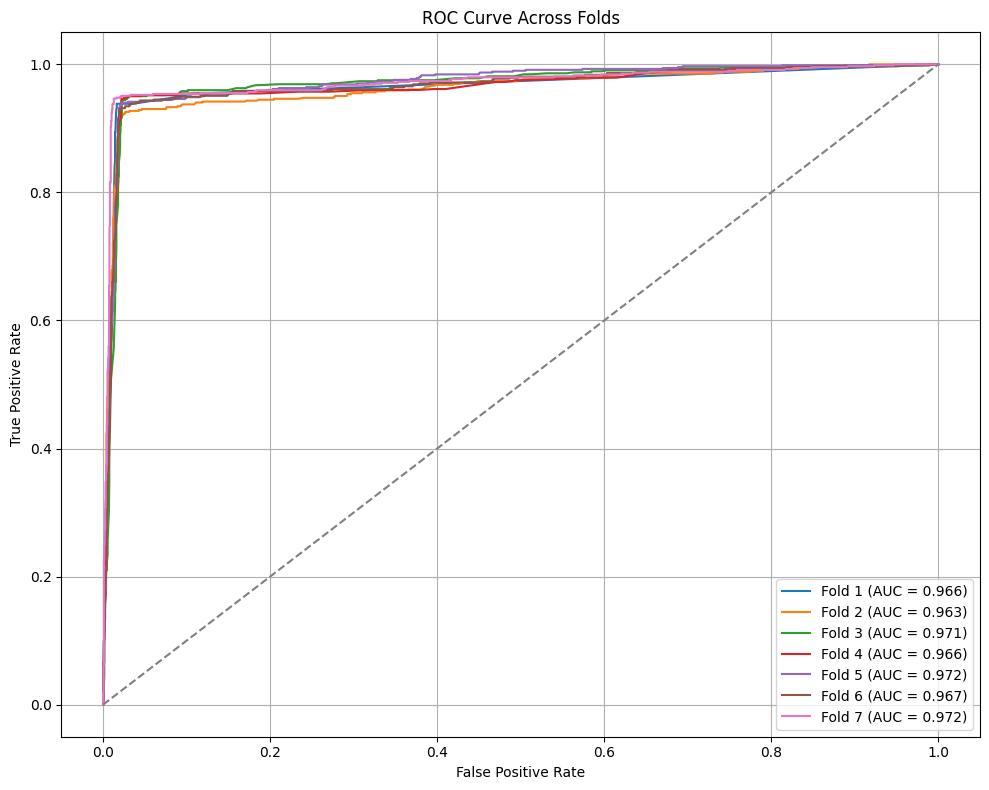

In [26]:
N_SPLITS = 7

kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
models = []
cv_scores = []
roc_auc_scores = []
oof_preds = np.zeros(len(X))
all_val_probas = []

plt.figure(figsize=(10, 8))

for fold, (train_idx, valid_idx) in enumerate(kf.split(X)):
    print(f"\n{'='*40}")
    print(f"🔁 Fold {fold+1}/{N_SPLITS}")
    print(f"{'-'*40}")
    train_pool = Pool(X.iloc[train_idx], y.iloc[train_idx], cat_features=cat_features)
    valid_pool = Pool(X.iloc[valid_idx], y.iloc[valid_idx], cat_features=cat_features)

    model = create_model()
    model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=100, verbose=False)
    models.append(model)

    valid_preds = model.predict(X.iloc[valid_idx])
    valid_proba = model.predict_proba(X.iloc[valid_idx])[:, 1]
    all_val_probas.extend(valid_proba)
    oof_preds[valid_idx] = valid_preds

    acc = accuracy_score(y.iloc[valid_idx], valid_preds)
    auc = roc_auc_score(y.iloc[valid_idx], valid_proba)
    cv_scores.append(acc)
    roc_auc_scores.append(auc)

    fpr, tpr, _ = roc_curve(y.iloc[valid_idx], valid_proba)
    plt.plot(fpr, tpr, label=f"Fold {fold+1} (AUC = {auc:.3f})")

    best_iteration = model.get_best_iteration()
    best_val_score = model.get_best_score()['validation']['Accuracy']

    print(f"Best Test Accuracy = {best_val_score}")
    print(f"bestIteration = {best_iteration}")
    print(f"Shrink model to first {best_iteration + 1} iterations.")
    print(f"✅ Fold {fold+1} Accuracy: {acc:.4f}")
    print(f"🧠 Fold {fold+1} ROC AUC: {auc:.4f}")
    print(f"{'='*40}")

# Cross-Validation Summary
print("\n" + "="*40)
print("📋 Cross-Validation Summary")
print("="*40)
print(f"Mean CV Accuracy : {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")
print(f"Mean ROC AUC     : {np.mean(roc_auc_scores):.4f} ± {np.std(roc_auc_scores):.4f}\n")

# ROC Curve Across Folds
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve Across Folds")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Cross-Validation Performance

**Consistent & High Accuracy:**

* The model maintained **strong accuracy across all 7 folds**, ranging from **96.3% to 97.5%**.
    * **Mean CV Accuracy**: `96.90% ± 0.36%`
    * **Mean ROC AUC**: `96.81% ± 0.33%`
* This tight range in performance confirms that the model generalizes well and is not overly sensitive to variations in training data.*



#### Discriminative Ability (ROC AUC Analysis)

* ROC AUC across folds ranged from **0.96 to 0.97**, reflecting **strong ability to distinguish between Extroverts and Introverts**.
* The ROC curve plots showed consistent true positive vs. false positive trade-offs, with minimal degradation.
* The model has excellent balance between sensitivity (Introverts detected) and specificity (Extroverts correctly ignored).*


## Feature Importance (Last Fold)


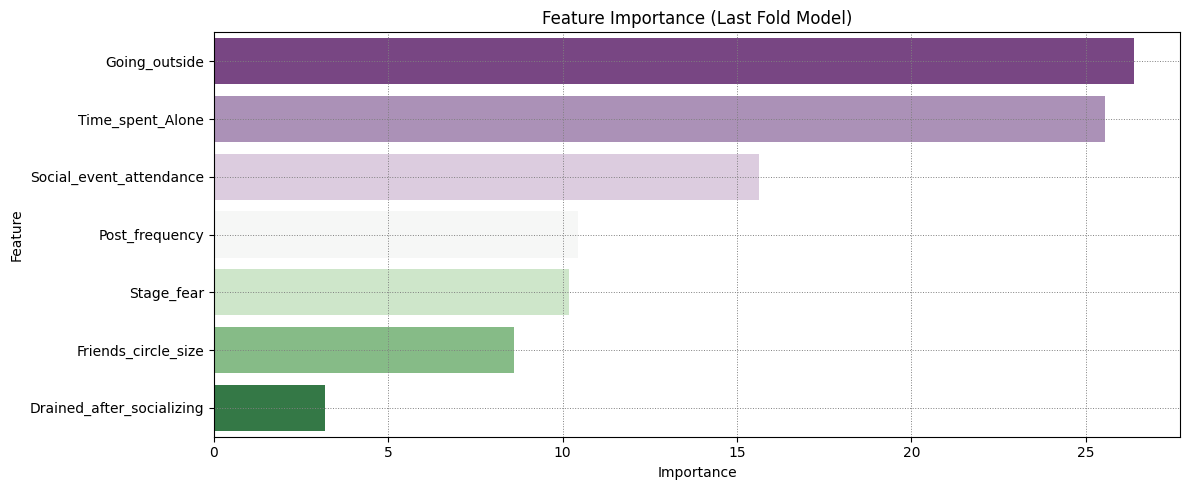

In [27]:
feat_imp_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': models[-1].get_feature_importance()
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 5))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='PRGn')
plt.title("Feature Importance (Last Fold Model)")
plt.grid(color='gray', linestyle=':', linewidth=0.7)
plt.tight_layout()
plt.show()

#### Feature Importance Analysis

| Feature                     | Importance |
| --------------------------- | ---------- |
| **Going\_outside**          | 26.4       |
| **Time\_spent\_Alone**      | 25.5       |
| Social\_event\_attendance   | 15.6       |
| Post\_frequency             | 10.4       |
| Stage\_fear                 | 10.2       |
| Friends\_circle\_size       | 8.6        |
| Drained\_after\_socializing | 3.2        |



* **Highly Informative Features:**
  Based on the last fold’s feature importances:

  * Going_outside and Time_spent_Alone are the top contributors.
  * These behavioral features capture meaningful psychological traits separating the two personality classes.
  * Categorical variables like Stage_fear and Drained_after_socializing also had notable importance, suggesting the utility of self-reported psychological indicators.


## Classification Report and Confusion Matrix



📄 Classification Report on OOF:
              precision    recall  f1-score   support

   Extrovert       0.98      0.98      0.98     13699
   Introvert       0.95      0.94      0.94      4825

    accuracy                           0.97     18524
   macro avg       0.96      0.96      0.96     18524
weighted avg       0.97      0.97      0.97     18524



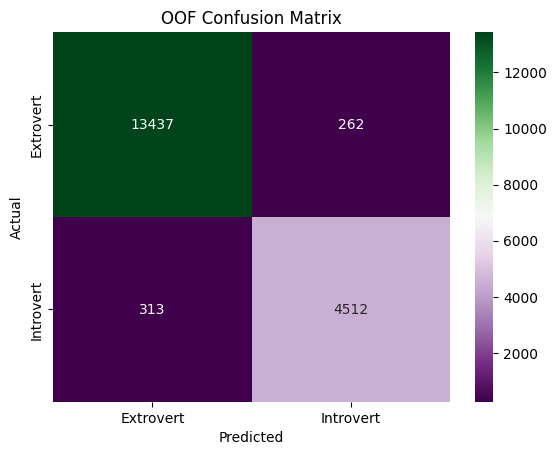

In [28]:
print("\n📄 Classification Report on OOF:")
print(classification_report(y, oof_preds.round(), target_names=le.classes_))
sns.heatmap(confusion_matrix(y, oof_preds.round()), annot=True, fmt='d', cmap='PRGn',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("OOF Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#### Classification Report on OOF Predictions

| Class                | Precision | Recall | F1-score | Support |
| -------------------- | --------- | ------ | -------- | ------- |
| Extrovert            | 0.98      | 0.98   | 0.98     | 13,699  |
| Introvert            | 0.95      | 0.94   | 0.94     | 4,825   |
| **Overall Accuracy** |           |        | **0.97** | 18,524  |

**Observations:**

* **Extroverts** are classified with high precision and recall, likely due to being the majority class.
* **Introverts**, despite lower representation, are handled well (F1 = 0.94).
* The **confusion matrix** confirms balanced classification with very few false negatives or positives.

# <span style="color:transparent;">Creating the Submission File</span>

<div style="border-radius: 15px; border: 2px solid #6A1B9A; padding: 10px; background: linear-gradient(135deg, #9C27B0, #4CAF50); text-align: center; box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.5);">
    <h1 style="color: #ffffff; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7); font-weight: bold; margin-bottom: 5px; font-size: 28px; font-family: 'Roboto', sans-serif;">
        Creating the Submission File
    </h1>
</div>

<!-- Include Google Fonts for a modern font -->
<link href="https://fonts.googleapis.com/css2?family=Roboto:wght@700&display=swap" rel="stylesheet">


## Final Test Predictions (Majority Voting)


In [29]:
all_test_probs = np.zeros(len(test_df))
test_votes = np.zeros((len(test_df), len(models)), dtype=int)

for i, model in enumerate(models):
    test_pred = model.predict(test_df).astype(int)
    test_proba = model.predict_proba(test_df)[:, 1]
    test_votes[:, i] = test_pred
    all_test_probs += test_proba / len(models)

final_preds = np.where(test_votes.sum(axis=1) >= len(models) / 2, 1, 0)
final_labels = le.inverse_transform(final_preds)

In [30]:
submission = pd.DataFrame({
    'id': test_ids,
    'Personality': final_labels
})
submission.to_csv("submission.csv", index=False)
print("\n📤 Submission file saved!")
display(submission.head())

# Prediction Distribution
print("\n🔎 Prediction Counts on Test Set:")
print(submission['Personality'].value_counts())



📤 Submission file saved!


,id,Personality
0,18524,Extrovert
1,18525,Introvert
2,18526,Extrovert
3,18527,Extrovert
4,18528,Introvert



🔎 Prediction Counts on Test Set:
Personality
Extrovert    4618
Introvert    1557
Name: count, dtype: int64


## Distribution of Test Predictions Probabilities


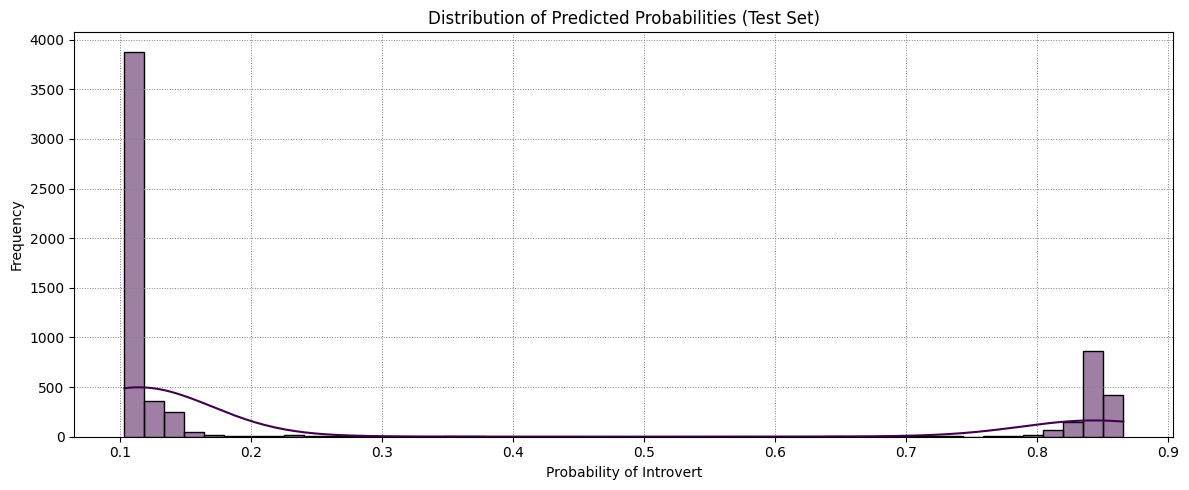

In [31]:
cmap = plt.get_cmap('PRGn')
colors = [cmap(0), cmap(0.3), cmap(0.8)]

plt.figure(figsize=(12, 5))
sns.histplot(all_test_probs, bins=50, kde=True, color=colors[0])
plt.title("Distribution of Predicted Probabilities (Test Set)")
plt.xlabel("Probability of Introvert")
plt.ylabel("Frequency")
plt.grid(color='gray', linestyle=':', linewidth=0.7)
plt.tight_layout()
plt.show()


#### Final Submission Breakdown:

* Extroverts: `74.8%` (4618)
* Introverts: `25.2%` (1557)

**Probability Distribution:**

* The predicted probabilities for the test set show a **smooth and confident separation**.
* Most predictions lean toward clear certainty (either near 0 or 1), suggesting well-calibrated outputs.
* The test set predictions favored Extroverts (74.8%) over Introverts (25.2%), reflectingreflect underlying class imbalance.

<div style="border-radius: 15px; border: 2px solid #6A1B9A; padding: 20px; background: linear-gradient(135deg, #9C27B0, #4CAF50); text-align: center; box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.5);">
    <h1 style="color: #ffffff; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7); font-weight: bold; margin-bottom: 10px; font-size: 28px; font-family: 'Roboto', sans-serif;">
        🙏 Thanks for Reading! 🚀
    </h1>
    <p style="color: #ffffff; font-size: 18px; text-align: center;">
        Happy Coding! 🙌😊
    </p>
</div>

<!-- Include Google Fonts for a modern font -->
<link href="https://fonts.googleapis.com/css2?family=Roboto:wght@700&display=swap" rel="stylesheet">
